## Uncertainty Estimation

We have seen that it was possible to obtain reasonably good estimates of the parameters, even with noisy fields values. However, it is crucial for practical application to also have an estimation uncertainty. 

In order to obtain uncertainty estimation values, we need to introduce a Bayesian framework. This means introducing some priors over the parameters. This should not be an issue since we normally would have nominal values for the components, or at least reasonable guesses or intervals for the values. 

Next we need to decide how to frame the optimization in the Bayesian framework. Here are some options: 

1. MAP estimate & Laplace estimate around the posterior mode: with this approach the prior influences the optimization with via a penalty term on the loss. Gradient based optimization (Adam) can then be employed to find the optimum, which in this case would be the MAP estimate. Finally, we assume the posterior is a Gaussian and we calculate the best fit using the Laplace approximation, which relies on computing the Hessian.

2. VI approach: should still be possible to use automatic-diff + Adam. 

3. HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

4. Expectation Propagation (EP) Approaches: good with time-series. To be investigated. 

## Prior Distribution Family over the Physical Parameters

In [2]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import h5py
import numpy as np


# change the working directory to the root of the project
sys.path.append(str(Path.cwd().parent))


from pinn_buck.config import Parameters
from pinn_buck.config import TRUE as TRUE_PARAMS, INITIAL_GUESS as INITIAL_GUESS_PARAMS
from pinn_buck.config import _SCALE

# load measurement interface
from pinn_buck.io import Measurement
from pinn_buck.noise import add_noise_to_Measurement

from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.model.model_param_estimator import BuckEstimatorCached
from pinn_buck.model.losses import l2_loss
from pinn_buck.io_model import TrainingRun

from pinn_buck.io import LoaderH5

### Parameter Nominal Values 

Now we need to define some nominal values for the parameters together with some realistic uncertainty estimates to simulate real engineering tasks. 

| Parameter | Description           | Nominal (N) | Tolerance / σ | Justification                      |
| --------- | --------------------- | ----------- | ------------- | ---------------------------------- |
| L         | Inductance            | 680 µH      | ±20%          | ±20% common for inductors          |
| RL        | Inductor resistance   | 0.3 Ω       | ±0.1 Ω        | DCR variation or estimation        |
| C         | Output capacitance    | 150 µF      | ±20%          | Electrolytics have wide tolerances |
| RC        | ESR of output cap     | 0.25 Ω      | ±40%          | Datasheet often gives a max        |
| Rdson     | Switch on-resistance  | 0.2 Ω       | ±10%          | MOSFETs vary with temperature      |
| Rload1    | Load resistor 1       | 3.3 Ω       | ±5%           | Depends on load spec               |
| Rload2    | Load resistor 2       | 10 Ω        | ±5%           | As above                           |
| Rload3    | Load resistor 3       | 6.8 Ω       | ±5%           | As above                           |
| Vin       | Input voltage         | 48 V        | ±2%           | From a regulated supply            |
| VF        | Diode forward voltage | 0.9 V       | ±0.1 V        | Varies with current/temperature    |


---

### Prior distribution family:
 we have to consider **Additive vs. Multiplicative Variation**.

* **Additive variation** means the component deviates by **adding or subtracting** some noise:

  $$
  x = x_0 + \epsilon
  \quad\text{(e.g., } \epsilon \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  This is typical of **normal (Gaussian)** noise.

* **Multiplicative variation** means the component value varies by being **scaled** up or down:

  $$
  x = x_0 \cdot (1 + \delta)
  \quad\text{(e.g., } \delta \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  Or more generally:

  $$
  \log x \sim \mathcal{N}(\mu, \sigma^2)
  \Rightarrow x \sim \text{LogNormal}(\mu, \sigma^2)
  $$

  This results in a **log-normal distribution** in linear space.

Considering how the components are manufactured:

* Component tolerances are often specified **as a percentage** (e.g., ±5%, ±10%).
* This means that the error **scales** with the magnitude.
* Example:

  * A 1 kΩ resistor with 5% tolerance → 950–1050 Ω
  * A 10 kΩ resistor with 5% tolerance → 9500–10500 Ω
    So the **absolute error grows** with the nominal value.

---

### Implication for Priors

If component values are specified with **percentage tolerances**, then we should model the distributions as:

$$
\log(x) \sim \mathcal{N}(\log(x_0), \sigma^2)
\quad\Rightarrow\quad
x \sim \text{LogNormal}
$$

This ensures:

* **Positivity**
* **Correct scaling of uncertainty**
* **Realistic tails** (e.g., 3σ errors reflect real-world max/min limits)


A log-normal distribution is suitable because:

* All parameters are positive
* Datasheet tolerances are multiplicative (e.g. ±20%)

For each parameter θ:

$$
p(\theta) = \frac{1}{\theta \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log \theta - \mu)^2}{2\sigma^2} \right)
$$

Where:

* μ = log(nominal value)
* σ = log(1 + relative tolerance)

## Notes
it may be more realistic to set a normal or truncated normal for some parameters, e.g. V_in, R_loads, but for now let's assume a lognormal for all components. 

However, setting all priors to be a log-normal is a good initial choice, since: 

1. Log-normal distributions naturally enforce positivity, which is a desirable property for **every parameter** in your model.

2. If the **relative standard deviation** is small (say < 10%), then a log-normal is **almost symmetric** and looks very much like a normal.

3. Modeling simplicity of using a log-normal for all parameters means:
    * One consistent implementation for priors
    * All prior PDFs live in log-space → simple KL terms in VI
    * Posterior approximations (Laplace, variational) share the same structure

    This pays off during training, debugging, and when visualizing uncertainty.

---

### ⚠️ Risks of using Log-Normal 

The core issue here is **how the prior interacts with the likelihood** to shape the posterior when the prior is **skewed** (like a log-normal) and the likelihood is **tight** (very confident).
 
#### log-normal priors can become problematic in narrow posterior regimes

Log-normal distributions are **asymmetric**:

* The **mode** is less than the **mean**
* The density decays **faster** on the left (toward 0) than on the right

Now suppose the **likelihood (data)** is very confident about, say, $V_{in} = 48.1 \, \text{V}$, with very little uncertainty:

  1. The prior is **skewed right**:

      * Most mass is slightly above 48 V

      * The mode is < 48 V (since log-normal mode = exp(μ − σ²))

  2. The posterior, which is proportional to:

  $$
  \text{posterior} \propto \text{likelihood} \times \text{prior}
  $$

  gets **pulled** by this skewed prior.



> If the data is highly informative and points to a value slightly **above** the nominal (e.g. 48.1 V), the **log-normal prior puts less mass there** than a normal would. 
    * The posterior mean gets **pulled lower**
    * The posterior becomes **skewed left**
    * The Laplace approximation (Gaussian) might **not match** the real shape

So if your posterior is very concentrated and the prior is skewed, **even a small mismatch** between the likelihood peak and the prior mode can:

* Shift the posterior
* Lead to incorrect uncertainty quantification
* Mislead downstream predictions if you're sampling
    Result:


---

## ✅ Why a normal prior helps in this case

A **normal prior** is symmetric. So:

* It doesn't bias the posterior toward lower or higher values
* The posterior stays centered where the data wants it to be
* The Laplace (or mean-field VI) approximation is more accurate

In summary, consider changing to a normal only if:

* The posteriors for $V_{in}$ or $R_{\text{load}}$ are **very tightly concentrated**, and
* Your Laplace or VI posterior is **asymmetric or biased** due to the log-normal prior's skew


In [3]:
import matplotlib
from scipy.stats import lognorm
from pinn_buck.config import Parameters


# Nominals and linear-space relative tolerances
NOMINAL = Parameters(
    L=6.8e-4,
    RL=0.4,
    C=1.5e-4,
    RC=0.25,
    Rdson=0.25,
    Rload1=3.3,
    Rload2=10.0,
    Rload3=6.8,
    Vin=46.0,
    VF=1.1,
)

REL_TOL = Parameters(
    L=0.50,
    RL=0.4,
    C=0.50,
    RC=0.50,
    Rdson=0.5,
    Rload1=0.3,
    Rload2=0.3,
    Rload3=0.3,
    Vin=0.3,
    VF=0.3,
)


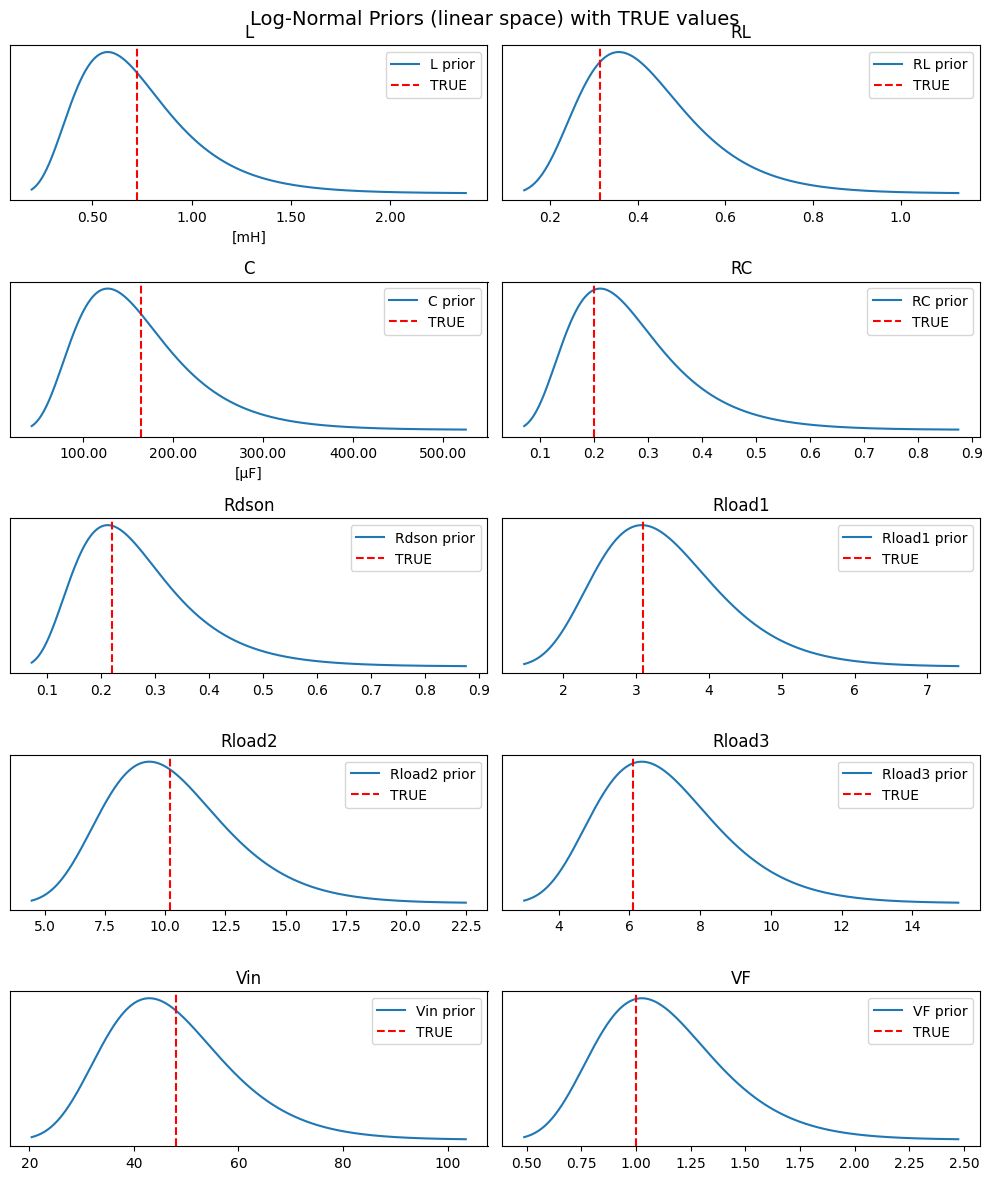

In [4]:

%matplotlib inline
import matplotlib.pyplot as plt

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()

for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()
    
    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Benchmark

Let's inspect a normal run of the Adam optimizer with the nominal values as initial guess

In [5]:
import torch
import torch.nn as nn

from pinn_buck.model.model_param_estimator import BuckParamEstimator, BuckParamEstimator1

def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def incremental_residual_loss(
    pred: torch.Tensor, observations: torch.Tensor
): 
    """
    Computes the incremental residual loss for a batch of predictions and observations.
    
    Args:
        pred (torch.Tensor): Predicted values, shape (batch_size, num_samples, num_features).
        observations (torch.Tensor): Observed values, shape (batch_size, num_samples, num_features).
    
    Returns:
        torch.Tensor: The computed loss value.
    """
    # Compute the incremental residuals
    delta_pred = pred[:, 1:] - pred[:, :-1]
    delta_obs = observations[:, 1:] - observations[:, :-1]
    
    # Compute the L2 loss between the incremental residuals
    loss = nn.functional.mse_loss(delta_pred, delta_obs)
    
    return loss

def mse_loss(pred: torch.Tensor, observations: torch.Tensor) -> torch.Tensor:
    """
    Computes the mean squared error loss between predictions and observations.
    
    Args:
        pred (torch.Tensor): Predicted values, shape (batch_size, num_samples, num_features).
        observations (torch.Tensor): Observed values, shape (batch_size, num_samples, num_features).
    
    Returns:
        torch.Tensor: The computed loss value.
    """
    # Compute the L2 loss
    delta_pred = pred - observations
    loss = nn.functional.mse_loss(delta_pred, torch.zeros_like(delta_pred))
    return loss


def fw_bw_mse_loss(
    pred_np1: torch.Tensor,
    pred_n: torch.Tensor,
    observations_np1: torch.Tensor,
    observations_n: torch.Tensor,
) -> torch.Tensor:

    """
    combine the residuals directly from the forward and backward predictions
    """
    # Compute the residuals for both predictions
    residual_np1 = pred_np1 - observations_np1
    residual_n = pred_n - observations_n

    # Combine the residuals
    combined_residuals = residual_np1 + residual_n

    # Compute the mean squared error loss
    loss = nn.functional.mse_loss(combined_residuals, torch.zeros_like(combined_residuals))

    return loss


def train_from_measurement_file(
    meas: Measurement,
    initial_guess_params: Parameters,
    savename: str = "saved_run",
    db_dir: Path = ".",
    lr: float = 1e-3,
    epochs: int = 30_000,
    device: str = "cpu",
    patience: int = 5000,
    lr_reduction_factor: float = 0.5,
):
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)
    x0 = X_t[:, :2]

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)

    history_loss = []
    history_params: List[Parameters] = []
    learning_rates: List[float] = []

    # --- tracking best loss ---
    best_loss, best_iter = float("inf"), -1

    # Optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_reduction_factor, patience=patience
    )

    for it in range(epochs):
        optimizer.zero_grad()
        i_n, v_n, i_np1, v_np1 = model(X_t, y_t)
        # loss = compute_loss(pred, x0, y_t) if it < epochs1 else compute_L1_loss(pred, x0, y_t)

        pred_np1 = torch.cat((i_np1, v_np1), dim=1)
        pred_n = torch.cat((i_n, v_n), dim=1)
        
        targets_np1 = y_t
        targets_n = X_t.clone().detach()[:, :2]

        # loss_np1 = mse_loss(pred_np1, targets_np1)
        # loss_n = mse_loss(pred_n, targets_n)
        # loss = loss_np1 + loss_n
        
        loss = fw_bw_mse_loss(
            pred_np1=pred_np1,
            pred_n=pred_n,
            observations_np1=targets_np1,
            observations_n=targets_n,
        )
        
        loss.backward()

        optimizer.step()
        scheduler.step(loss)
        
        if it % 1000 == 0:
            est = model.get_estimates()
            history_loss.append(loss.item())
            history_params.append(est)
            # record the learning rate
            learning_rates.append(optimizer.param_groups[0]["lr"])

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_iter = it

            # print the parameter estimation
            est = model.get_estimates()
            print(
                f"Iteration {it}, loss {loss:4e},  Parameters (Adam):",
                f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
            )

    # Save the history to a CSV file
    training_run = TrainingRun.from_histories(
        loss_history=history_loss,
        param_history=history_params,
    )

    # generate the output directory if it doesn't exist
    db_dir.mkdir(parents=True, exist_ok=True)

    # if savename doesn't end with .csv, add it
    if not savename.endswith(".csv"):
        savename += ".csv"

    training_run.save_to_csv(db_dir / savename)
    print("Concluded ADAM training.")

In [6]:
set_seed(123)
device = "cpu"

# Load and assemble dataset
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    3: "5 noise",
    4: "10 noise",
}


lr = 1e-3
epochs = 20_000
patience = 5000
device = "cpu"  # or "cuda" if you have a GPU
lr_reduction_factor = 0.5


out_dir = Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "f&b_combined_residual" 

# noisy_measurements = {}
# for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
#     if "Sync" in group_name:
#         # Skip the Sync Error group for now
#         continue
#     print(f"Loading group {group_number}: {group_name}")
#     # Load the data from the hdf5 file
#     io = LoaderH5(db_dir, h5filename)
#     io.load(group_name)

#     # Store the measurement in a dictionary
#     noisy_measurements[group_name] = io.M

#     print(f"\n{'-'*50}")
#     print(f"{idx}) Training with {group_name} data")

#     # Train the model on the noisy measurement
#     train_from_measurement_file(
#         io.M,
#         initial_guess_params= NOMINAL,
#         db_dir=out_dir,
#         savename=f"noisy_run_{group_name}.csv",
#         lr=lr,
#         patience=patience,
#         lr_reduction_factor=lr_reduction_factor,
#         epochs=20_000,
#         device=device,
#     )

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


Text(0.5, 1.0, 'Forward & Backward')

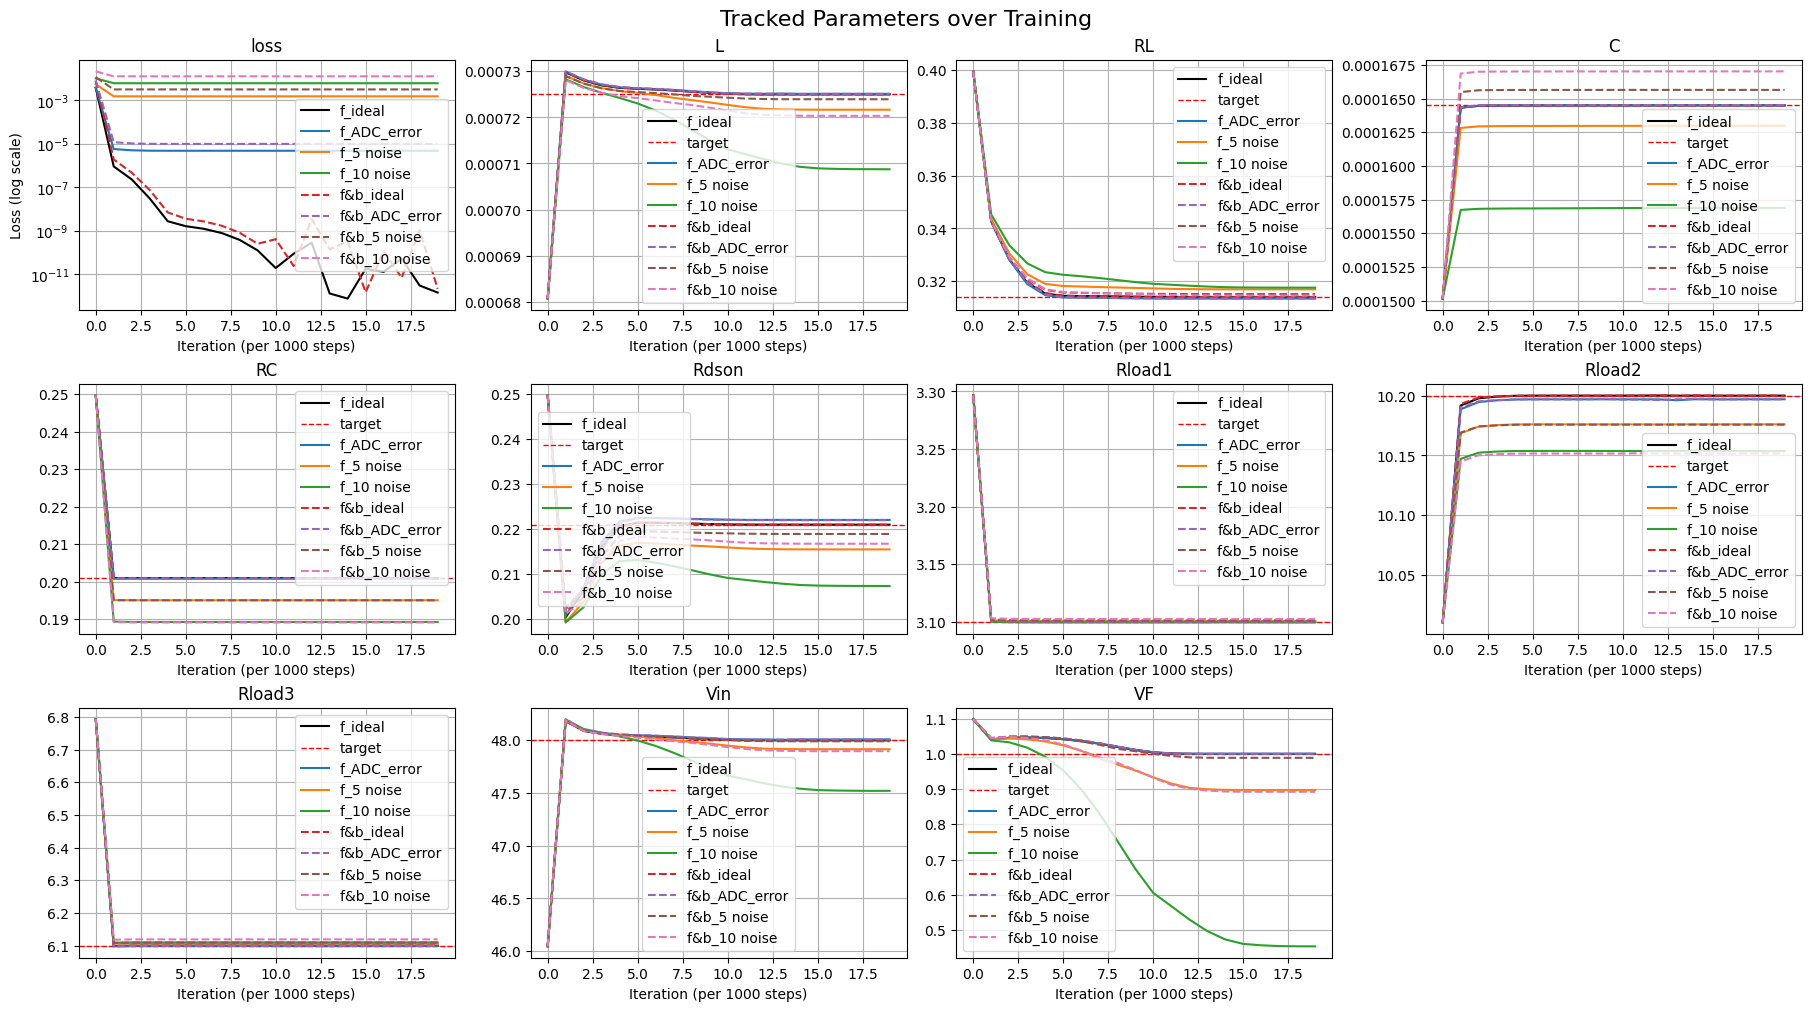

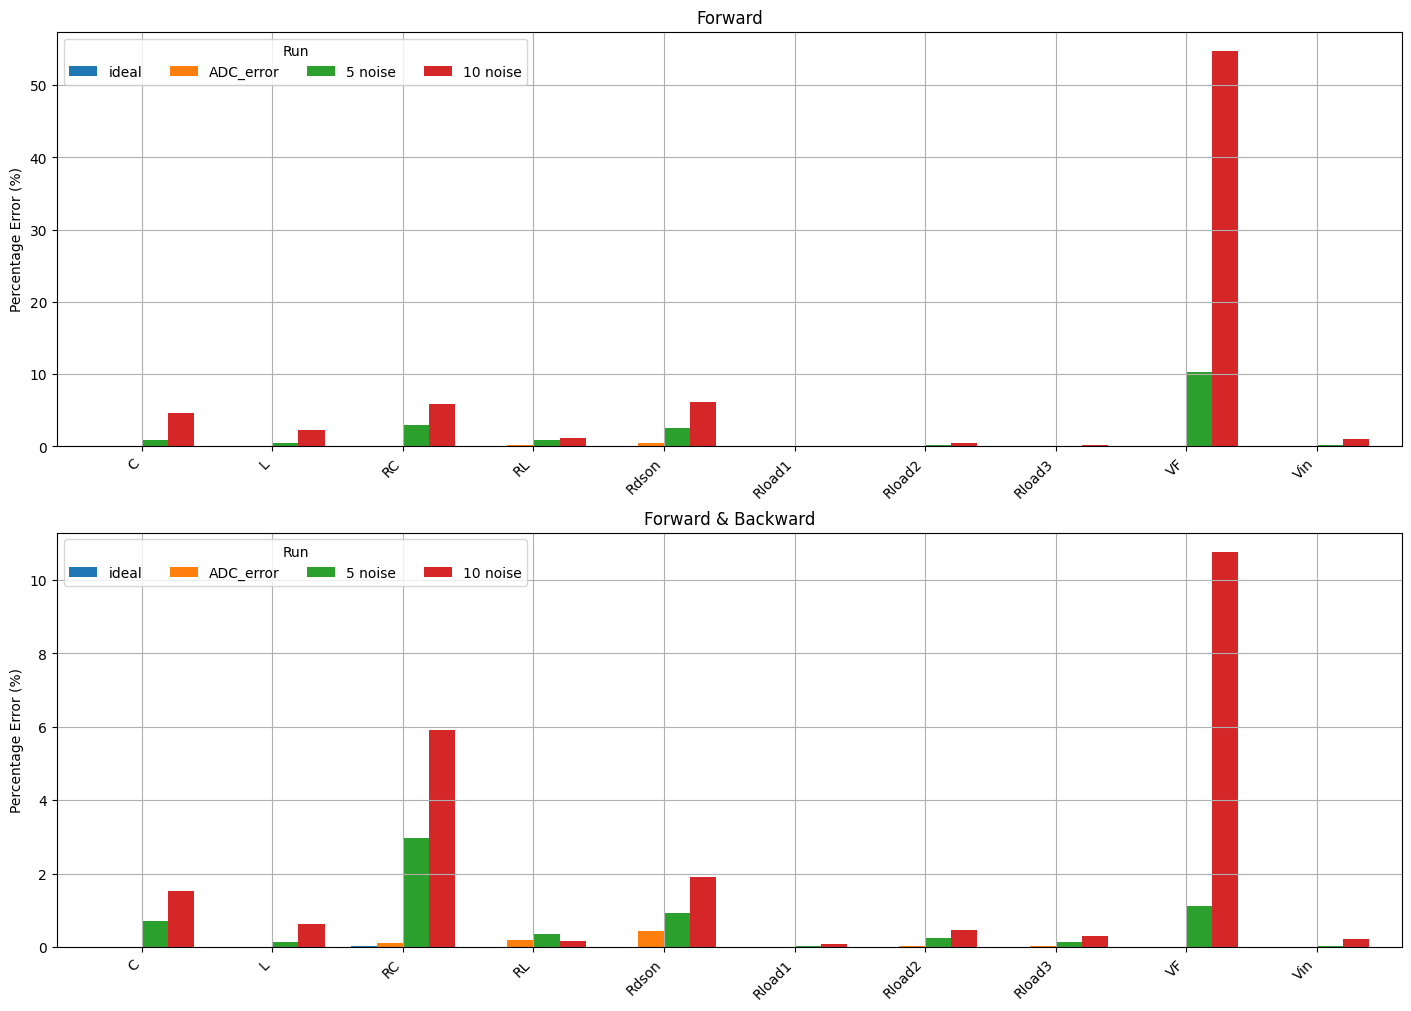

In [7]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
f_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward"
)


csv_files = list(f_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f_" + label
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_f = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


csv_files = list(fb_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]
    
    label = "f&b_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_fb = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_f, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax = ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_fb, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax = ax[1]
)

ax[0].set_title("Forward")
ax[1].set_title("Forward & Backward")

## Consider residual correlation

In [8]:
# get data noise values

# ADC noise is 1 LSB, so we can assume that the data noise is 1 LSB
# 5 noise is 5 LSB, 10 noise is 10 LSB

# A least significant bit (LSB) is the smallest unit of data in a digital system and is calculated as:
#         LSB_i = I_FS / (2**12 - 1)  # assuming 12-bit ADC
#         LSB_v = V_FS / (2**12 - 1)  # assuming 12-bit ADC

# where I_FS is the full-scale current, set to 10 A and V_FS is the full-scale voltage set to 30 V (see 03_inspect_noisy_data.ipynb).

# Then the noise level is calculated as:
#         noise_level_i = noise_level * LSB_i  # normalize noise level to LSB
#         noise_level_v = noise_level * LSB_v  # normalize noise level to LSB

lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2



In [11]:
from torch.autograd.functional import jacobian


# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model


def estimate_avg_Jacobian(model, X, y, max_samples=10) -> torch.Tensor:
    model.eval()
    X = X.detach()
    y = y.detach()

    jacobians_fw = []
    jacobians_bk = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        def f_noise_inputs_bk(y):
            x_input = x_n.unsqueeze(0)             # shape (1, 4)
            y_input = y.unsqueeze(0)           # shape (1, 2)
            i_n, v_n, _, _ = model(x_input, y_input)
            return torch.cat([i_n, v_n], dim=1).squeeze()

        def f_noisy_inputs_fw(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            _, _, i_np1, v_np1 = model(x_full, y_input)
            return torch.cat([i_np1, v_np1], dim=1).squeeze()

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        y_input = y_n.clone().detach().requires_grad_(True)
        J_fw = jacobian(f_noisy_inputs_fw, i_v_input)  # shape (2, 2)
        J_bk = jacobian(f_noise_inputs_bk, y_input)  # shape (2, 2)
        jacobians_fw.append(J_fw)
        jacobians_bk.append(J_bk)

    return torch.stack(jacobians_fw).mean(0), torch.stack(jacobians_bk).mean(0)  # average over all jacobians


jacobians_fw = {}
jacobians_bk = {}   

# Loop through all groups and estimate the Frobenius norm for each group

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model = load_data_to_model(io.M, initial_guess_params=NOMINAL)

    print(f"Estimating Jacobian for group {group_name}...")
    jac_fw, jac_bw = estimate_avg_Jacobian(model, X_t, y_t, max_samples=300)
    jacobians_fw[group_name] = jac_fw
    jacobians_bk[group_name] = jac_bw
    print(f"Forward Jacobain for group {group_name} ({jac_fw.shape}): {jac_fw}")
    print(f"Backward Jacobain for group {group_name} ({jac_bw.shape}): {jac_bw}")

# average the Frobenius norms across all groups
J_fw_av = torch.stack(list(jacobians_fw.values())).mean(0)
J_bw_av = torch.stack(list(jacobians_bk.values())).mean(0)

print(f"Average fw jacobian norm across all groups: {J_fw_av}")
print(f"Average bw jacobian norm across all groups: {J_bw_av}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Forward Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Backward Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 1.0173,  0.0382],
        [-0.1561,  1.0541]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Forward Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Backward Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 1.0173,  0.0382],
        [-0.1561,  1.0541]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Forward Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Backward Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 1.0173,  0.0382],
        [-0.1561,  1.0541]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Forward Jacobain for group 10 noise (torch.Size

In [16]:
# in theory, the Jacobian should be symmetric and the backward Jacobian should be the inverse of the forward Jacobian
# Check the symmetry and inverse properties

sym_error = torch.norm(J_fw_av @ J_bw_av - torch.eye(2))
inv_error = torch.norm(J_bw_av - torch.linalg.inv(J_fw_av))
print(f"Symmetry error ‖J_fw @ J_bw - I‖: {sym_error:.3e}")
print(f"Inverse error ‖J_bw - inv(J_fw)‖: {inv_error:.3e}")


J_av = 0.5 * (J_fw_av + torch.linalg.inv(J_bw_av))  
print(f"By using both forward and backward Jacobians, we can estimate the average Jacobian as:\n {J_av}")

# save the jacobian
jacobian_dir = Path.cwd().parent / "RESULTS" / "Jacobains" / "N0"
jacobian_dir.mkdir(parents=True, exist_ok=True)

torch.save(J_av, jacobian_dir / "jacobian.pt")
# save the nominal values of the parameters used for the Jacobian estimation
torch.save(NOMINAL, jacobian_dir / "nominal_params.pt")

Symmetry error ‖J_fw @ J_bw - I‖: 3.570e-04
Inverse error ‖J_bw - inv(J_fw)‖: 3.697e-04
By using both forward and backward Jacobians, we can estimate the average Jacobian as:
 tensor([[ 0.9776, -0.0354],
        [ 0.1446,  0.9434]])


In [74]:
# Now we have the jacobian we can calculate the Sigma matrix for the forward and backward optimization model
def noise_power_to_sigma(
    noise_power_i: float,
    noise_power_v: float,
    ) -> torch.Tensor:
    
    return torch.tensor(
        [
            [noise_power_i, 0.0],
            [0.0, noise_power_v]
        ],
        dtype=torch.float32,
    )

def estimate_sigma_fw_bw(
    sigma_x: torch.Tensor,
    J: torch.Tensor,
    calculate_diag_terms: bool = True,
): 
    def helper_diag_terms(
        sigma_x: torch.Tensor,
        J: torch.Tensor,
    ) -> torch.Tensor:
        """
        Helper function to compute the diagonal terms of the Sigma matrix.
        """
        return J @ sigma_x @ J.T + sigma_x
    
    j_inv: torch.Tensor = torch.linalg.inv(J)

    if calculate_diag_terms:
        sig_12 = - J @ sigma_x - sigma_x @ j_inv.T
        sig_21 = - j_inv @ sigma_x - sigma_x @ J.T
        
    else:
        sig_12 = torch.zeros((2, 2), device=sigma_x.device)
        sig_21 = torch.zeros((2, 2), device=sigma_x.device)
    
    # build the 4x4 Sigma matrix
    Sigma = torch.zeros((4, 4), device=sigma_x.device)
    Sigma[:2, :2] = helper_diag_terms(sigma_x, J)  # top-left
    Sigma[:2, 2:] = sig_12  # top-right
    Sigma[2:, :2] = sig_21  # bottom-left
    Sigma[2:, 2:] = helper_diag_terms(sigma_x, j_inv)
    
    return Sigma

def ensure_positive_definite(Sigma: torch.Tensor) -> torch.Tensor:
    """
    Ensure the Sigma matrix is positive definite by adding a small value to the diagonal.
    """
    return Sigma + torch.eye(Sigma.shape[0], device=Sigma.device) * 1e-6


sigma_adc = estimate_sigma_fw_bw(
    noise_power_to_sigma(
        noise_power_ADC_i,
        noise_power_ADC_v,
    ),
    J_av,
)
sigma_5 = estimate_sigma_fw_bw(
    noise_power_to_sigma(
        noise_power_5_i,
        noise_power_5_v,
    ),
    J_av,
)
sigma_10 = estimate_sigma_fw_bw(
    noise_power_to_sigma(
        noise_power_10_i,
        noise_power_10_v,
    ),
    J_av,
)


print(f"Sigma matrix for ADC noise:\n{sigma_adc}")
print(f"Sigma matrix for 5 LSB noise:\n{sigma_5}")
print(f"Sigma matrix for 10 LSB noise:\n{sigma_10}")


sigma_adc = ensure_positive_definite(sigma_adc)
sigma_5 = ensure_positive_definite(sigma_5)
sigma_10 = ensure_positive_definite(sigma_10)

print("______________________")
print("Ensured positive definiteness of Sigma matrices:")
print(f"Sigma matrix for ADC noise:\n{sigma_adc}")
print(f"Sigma matrix for 5 LSB noise:\n{sigma_5}")
print(f"Sigma matrix for 10 LSB noise:\n{sigma_10}")


# investigate positive definiteness of the Sigma matrices
def is_positive_definite(matrix: torch.Tensor) -> bool:
    """Check if a matrix is positive definite."""
    return torch.all(torch.real(torch.linalg.eigvals(matrix)) > 0)


def distance_to_pd(Sigma):
    eigvals = torch.linalg.eigvals(Sigma)
    neg_part = torch.clamp(torch.real(eigvals), max=0).abs()
    return neg_part.sum().item()


print(f"Distance to positive definiteness for ADC noise: {distance_to_pd(sigma_adc):.3e}")
print(f"Distance to positive definiteness for 5 LSB noise: {distance_to_pd(sigma_5):.3e}")
print(f"Distance to positive definiteness for 10 LSB noise: {distance_to_pd(sigma_10):.3e}")

Sigma matrix for ADC noise:
tensor([[ 1.1729e-05, -9.4804e-07, -1.1896e-05,  2.8285e-06],
        [-9.4804e-07,  1.0156e-04, -2.9097e-06, -1.0721e-04],
        [-1.1896e-05, -2.9097e-06,  1.2213e-05,  1.2122e-06],
        [ 2.8285e-06, -1.0721e-04,  1.2122e-06,  1.1346e-04]])
Sigma matrix for 5 LSB noise:
tensor([[ 2.9323e-04, -2.3701e-05, -2.9740e-04,  7.0712e-05],
        [-2.3701e-05,  2.5390e-03, -7.2742e-05, -2.6802e-03],
        [-2.9740e-04, -7.2742e-05,  3.0533e-04,  3.0306e-05],
        [ 7.0712e-05, -2.6802e-03,  3.0306e-05,  2.8365e-03]])
Sigma matrix for 10 LSB noise:
tensor([[ 1.1729e-03, -9.4804e-05, -1.1896e-03,  2.8285e-04],
        [-9.4804e-05,  1.0156e-02, -2.9097e-04, -1.0721e-02],
        [-1.1896e-03, -2.9097e-04,  1.2213e-03,  1.2122e-04],
        [ 2.8285e-04, -1.0721e-02,  1.2122e-04,  1.1346e-02]])
______________________
Ensured positive definiteness of Sigma matrices:
Sigma matrix for ADC noise:
tensor([[ 1.2729e-05, -9.4804e-07, -1.1896e-05,  2.8285e-06],
  

In [72]:
torch.linalg.eigvals(sigma_adc), torch.linalg.eigvals(sigma_5), torch.linalg.eigvals(sigma_10)

(tensor([1.0000e-06+0.j, 2.5004e-05+0.j, 2.1596e-04+0.j, 1.0000e-06+0.j]),
 tensor([5.3749e-03+0.j, 6.0111e-04+0.j, 1.0000e-06+0.j, 1.0001e-06+0.j]),
 tensor([2.1497e-02+0.0000e+00j, 2.4014e-03+0.0000e+00j, 1.0004e-06+5.3550e-10j,
         1.0004e-06-5.3550e-10j]))

In [ ]:
# now train with loss r Sigma^{-1} r^T loss
def fw_bw_loss_with_sigma(
    pred_np1: torch.Tensor,
    pred_n: torch.Tensor,
    observations_np1: torch.Tensor,
    observations_n: torch.Tensor,
    precision_matrix: torch.Tensor,
) -> torch.Tensor:
    """
    Compute the loss with the Sigma matrix.
    """
    # Compute the residuals for both predictions
    residual_np1 = pred_np1 - observations_np1  # shape (batch_size, 2)
    residual_n = pred_n - observations_n  # shape (batch_size, 2)

    # residual vector
    r = torch.cat((residual_np1, residual_n), dim=1)  # shape (batch_size, 4)

    # Compute the loss as r^T Sigma^{-1} r
    mahal = torch.einsum("Bi, ij, Bj -> B", r, precision_matrix, r)  # shape (batch_size,)
    return 0.5 * mahal.sum()  # scalar


def fw_bw_loss_whitened(
    pred_np1: torch.Tensor,
    pred_n: torch.Tensor,
    observations_np1: torch.Tensor,
    observations_n: torch.Tensor,
    L_inv: torch.Tensor,
) -> torch.Tensor:
    """
    Compute r^T Σ^{-1} r via Cholesky whitening: r -> z = L^{-1} r.
    """
    residual_np1 = pred_np1 - observations_np1  # shape (batch_size, 2)
    residual_n = pred_n - observations_n  # shape (batch_size, 2)
    r = torch.cat((residual_np1, residual_n), dim=1)  # (B, 4)

    z = torch.matmul(r, L_inv.T)  # whitening: (B, 4)
    return 0.5 * (z**2).sum()


def train_from_measurement_file(
    meas: Measurement,
    sigma: torch.Tensor,
    initial_guess_params: Parameters,
    savename: str = "saved_run",
    db_dir: Path = ".",
    lr: float = 1e-3,
    epochs: int = 30_000,
    device: str = "cpu",
    patience: int = 5000,
    lr_reduction_factor: float = 0.5,
):
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)
    x0 = X_t[:, :2]

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)

    history_loss = []
    history_params: List[Parameters] = []
    learning_rates: List[float] = []

    # --- tracking best loss ---
    best_loss, best_iter = float("inf"), -1

    # Optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_reduction_factor, patience=patience
    )

    # # get the fixed inverse of the Sigma matrix
    # precision_matrix = torch.linalg.inv(sigma).to(device)

    # # remove the off diagonal 2x2 blocks
    # precision_matrix0 = torch.linalg.inv(sigma0).to(device)

    # remove the off diagonal 2x2 blocks
    sigma0 = sigma.clone().detach()
    sigma0[:2, 2:] = 0.0
    sigma0[2:, :2] = 0.0
    
    # Precompute L_inv for both full and diagonal Sigma
    L_diag = torch.linalg.cholesky(sigma0).to(device)
    L_full = torch.linalg.cholesky(sigma).to(device)
    L_inv_diag = torch.cholesky_inverse(L_diag)
    L_inv_full = torch.cholesky_inverse(L_full)

    # Define blend schedule
    ramp_start, ramp_end = 15000, 25000  # smooth transition over these epochs

    for it in range(epochs):
        optimizer.zero_grad()
        i_n, v_n, i_np1, v_np1 = model(X_t, y_t)
        # loss = compute_loss(pred, x0, y_t) if it < epochs1 else compute_L1_loss(pred, x0, y_t)

        pred_np1 = torch.cat((i_np1, v_np1), dim=1)
        pred_n = torch.cat((i_n, v_n), dim=1)

        targets_np1 = y_t
        targets_n = X_t.clone().detach()[:, :2]

        # loss_np1 = mse_loss(pred_np1, targets_np1)
        # loss_n = mse_loss(pred_n, targets_n)
        # loss = loss_np1 + loss_n

        if it < ramp_start:
            L_inv = L_inv_diag
        elif it >= ramp_end:
            L_inv = L_inv_full
        else:
            # Blend between diagonal and full
            alpha = (it - ramp_start) / (ramp_end - ramp_start)
            L_inv = (1 - alpha) * L_inv_diag + alpha * L_inv_full
        
        loss = fw_bw_loss_whitened(
            pred_np1=pred_np1,
            pred_n=pred_n,
            observations_np1=targets_np1,
            observations_n=targets_n,
            L_inv=L_inv,
        )

        loss.backward()

        optimizer.step()
        scheduler.step(loss)

        if it % 1000 == 0:
            est = model.get_estimates()
            history_loss.append(loss.item())
            history_params.append(est)
            # record the learning rate
            learning_rates.append(optimizer.param_groups[0]["lr"])

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_iter = it

            # print the parameter estimation
            est = model.get_estimates()
            print(
                f"Iteration {it}, loss {loss:4e},  Parameters (Adam):",
                f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
            )

    # Save the history to a CSV file
    training_run = TrainingRun.from_histories(
        loss_history=history_loss,
        param_history=history_params,
    )

    # generate the output directory if it doesn't exist
    db_dir.mkdir(parents=True, exist_ok=True)

    # if savename doesn't end with .csv, add it
    if not savename.endswith(".csv"):
        savename += ".csv"

    training_run.save_to_csv(db_dir / savename)
    print("Concluded ADAM training.")

In [86]:
set_seed(123)
device = "cpu"

# Load and assemble dataset
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    3: "5 noise",
    4: "10 noise",
}


sigma_ideal = torch.eye(4, dtype=torch.float32)*1e-9

# GROUP_NUMBER_TO_SIGMA = {
#     0: sigma_ideal,
#     1: sigma_ideal,
#     3: sigma_ideal,
#     4: sigma_ideal,
# }

GROUP_NUMBER_TO_SIGMA = {
    0: sigma_ideal,
    1: sigma_adc,
    3: sigma_5,
    4: sigma_10,
}



lr = 1e-3
epochs = 35_000
patience = 5000
device = "cpu"  # or "cuda" if you have a GPU
lr_reduction_factor = 0.5


out_dir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_matrix_loss_form"
)

noisy_measurements = {}
for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    if idx == 0:
        # Skip the ideal group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    train_from_measurement_file(
        io.M,
        sigma=GROUP_NUMBER_TO_SIGMA[group_number],
        initial_guess_params= NOMINAL,
        db_dir=out_dir,
        savename=f"noisy_run_{group_name}.csv",
        lr=lr,
        patience=patience,
        lr_reduction_factor=lr_reduction_factor,
        epochs=35_000,
        device=device,
    )


Loading group 1: ADC_error

--------------------------------------------------
1) Training with ADC_error data
Iteration 0, loss 1.656298e+10,  Parameters (Adam): L=6.807e-04, RL=3.996e-01, C=1.502e-04, RC=2.498e-01, Rdson=2.498e-01, Rload1=3.297e+00, Rload2=1.001e+01, Rload3=6.793e+00, Vin=46.046, VF=1.099e+00
Iteration 1000, loss 1.657689e+07,  Parameters (Adam): L=7.305e-04, RL=3.443e-01, C=1.642e-04, RC=2.008e-01, Rdson=2.092e-01, Rload1=3.101e+00, Rload2=1.019e+01, Rload3=6.098e+00, Vin=48.257, VF=1.053e+00
Iteration 2000, loss 6.773958e+06,  Parameters (Adam): L=7.287e-04, RL=3.286e-01, C=1.644e-04, RC=2.008e-01, Rdson=2.066e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.099e+00, Vin=48.112, VF=1.061e+00
Iteration 3000, loss 5.218380e+06,  Parameters (Adam): L=7.277e-04, RL=3.213e-01, C=1.645e-04, RC=2.008e-01, Rdson=2.143e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.099e+00, Vin=48.086, VF=1.061e+00
Iteration 4000, loss 4.732950e+06,  Parameters (Adam): L=7.270e-04, RL=3

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


Text(0.5, 1.0, 'Forward & Backward')

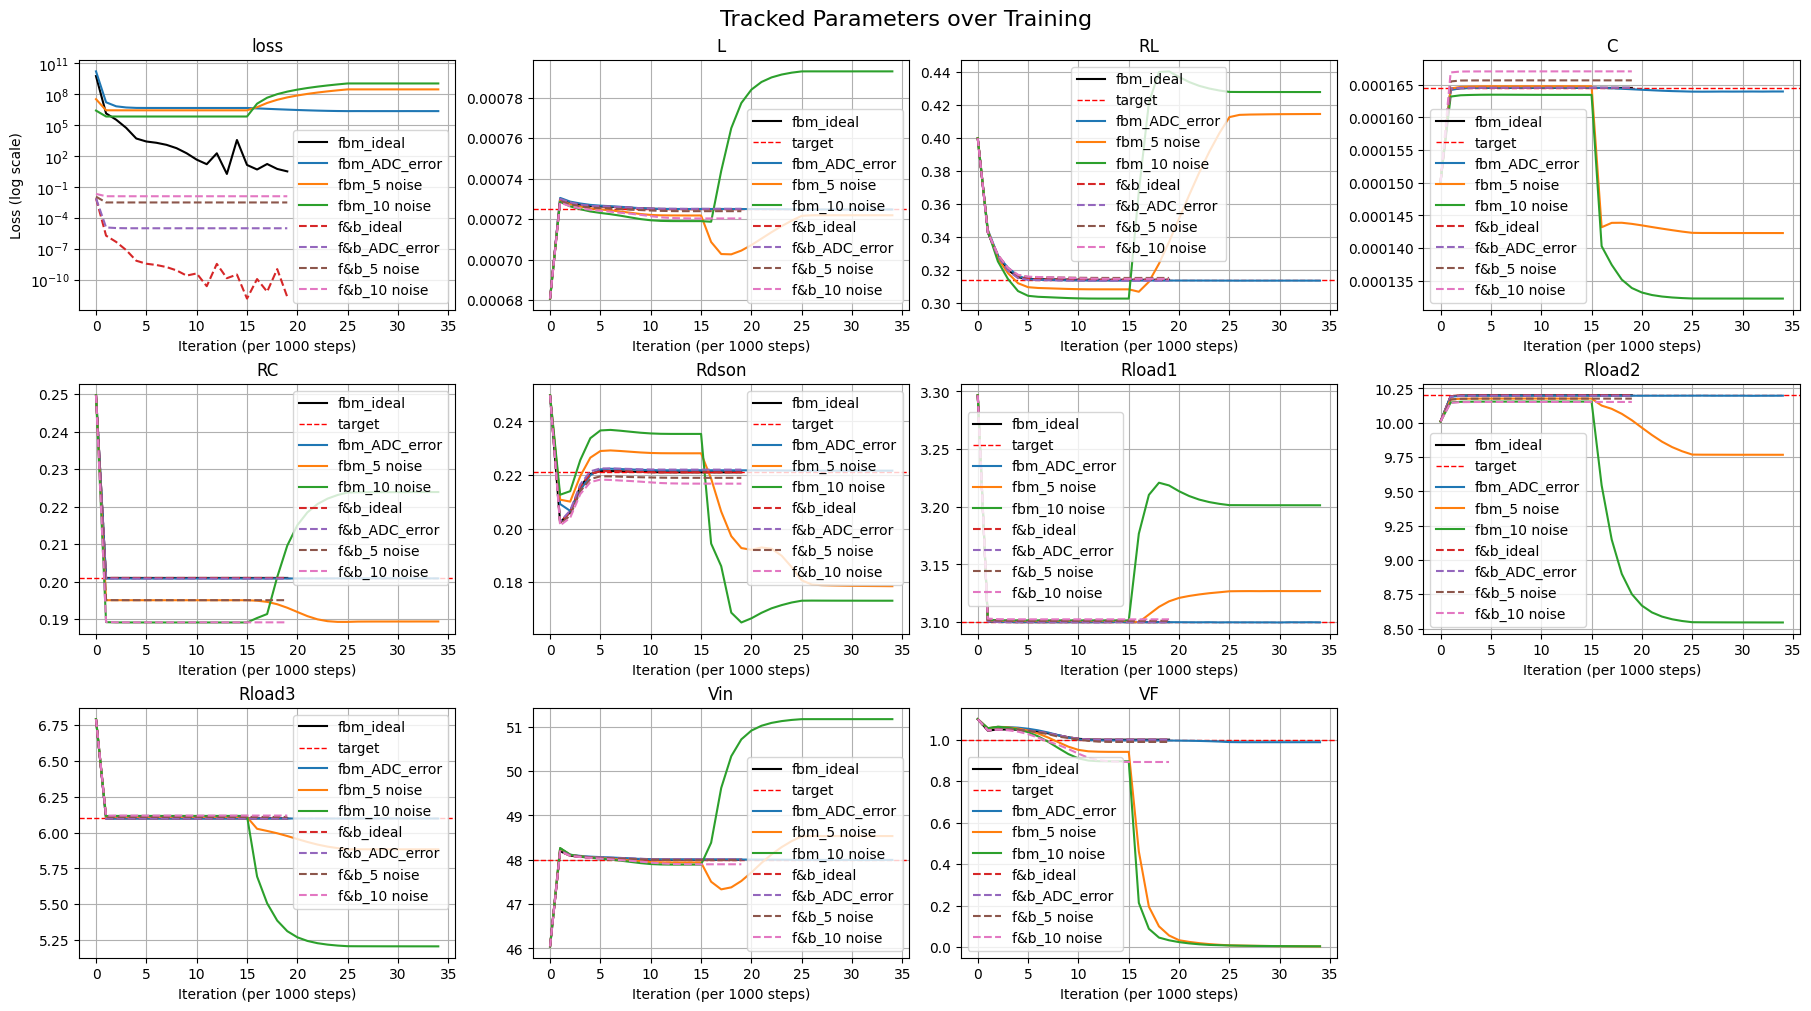

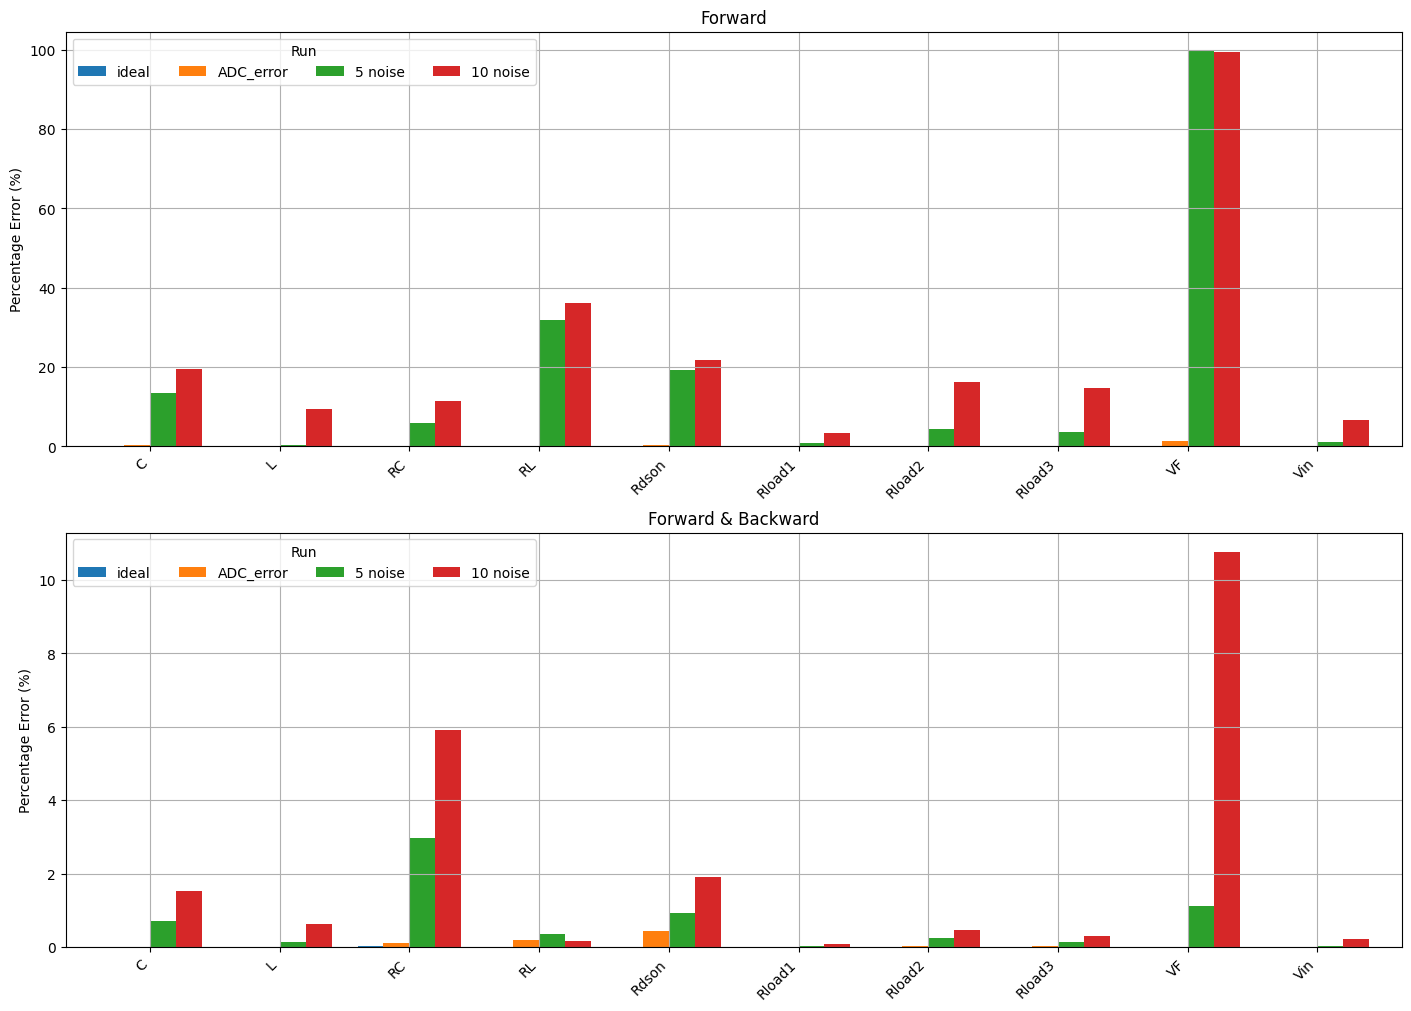

In [90]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
fbm_outdir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_matrix_loss_form"
)


csv_files = list(fbm_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "fbm_" + label
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_fbm = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


csv_files = list(fb_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f&b_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_fb = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_fbm, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_fb, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[1]
)

ax[0].set_title("Forward")
ax[1].set_title("Forward & Backward")

---

### Chapter: Why Adam Fails with Full-Covariance Mahalanobis Loss

#### 🧭 1. Background: Preconditioning and Curvature

In optimization, a **preconditioner** $P$ is used to transform gradients before stepping, effectively rescaling the loss landscape to reduce condition number and accelerate convergence. In quadratic minimization, the ideal preconditioner is $H^{-1}$, the inverse Hessian. Preconditioned gradient descent then becomes:



resulting in spherical level curves and stable convergence **if** $P\approx H^{-1}$ ([Wikipedia][1]).

---

#### 2. Adam’s Diagonal-Only Preconditioner

Adam adapts learning rates per-parameter using first and second moment estimates:



with update:



Here, the preconditioner $P_t^{-1} = \eta\,\operatorname{diag}(1/\sqrt{v_t+\epsilon})$ is **diagonal**, i.e., Adam rescales each parameter independently ([Massachusetts Institute of Technology][2]).

---

#### 3. The Problem: Full-Covariance Loss Requires a Full Preconditioner

When using a **full covariance Mahalanobis loss**



the Hessian becomes



where $J_n$ is the Jacobian of the residuals. Since $\Sigma_r^{-1}$ contains off-diagonal blocks, $H$ becomes **rotated**—its eigenvectors don’t align with parameter axes.

Because Adam only applies diagonal scaling, it fails to align with these rotated eigenvectors. As a result:

* In directions with **high curvature**, Adam overshoots, causing divergence.
* In directions with **low curvature**, Adam undershoots, stalling progress.

This mismatch between the optimizer’s axis-aligned scaling and the true anisotropic loss landscape leads to instability ([arXiv][3], [CS Princeton][4], [Department of Computer Science][5]).

---

#### 4. Experiments Show Adam Struggles on Non-Diagonal Hessians

Theoretical analysis confirms that Adam’s convergence depends on both condition number $\kappa(H)$ and the degree of non-diagonality. The effective condition number becomes $\min(d,\kappa)$ in simple cases, but performs poorly when the Hessian is highly non-diagonal ([arXiv][3]). Empirical reports also show Adam can even diverge on certain convex problems due to this limitation ([Massachusetts Institute of Technology][6]).


In summary, **Adam's diagonal scaling is fundamentally misaligned with rotated, full-covariance loss landscapes**, making it an unsuitable optimizer once off-diagonal covariance terms are introduced.


---

### Detailed illustration: diagonal vs full precision and alignment with parameter axes

Consider the two–parameter toy model

$$
\theta=(a,b), \qquad r(\theta)=\begin{bmatrix}a\\[2pt] b\end{bmatrix}.
$$

The Mahalanobis loss is

$$
\boxed{\;\mathcal{L}(a,b)=\tfrac12\,r^\top \Sigma^{-1} r\;}.
$$

---

#### 1 Diagonal precision ( $\Sigma^{-1}=I$ )

**Loss**

$$
\mathcal{L}_{\text{diag}}=\tfrac12\,(a^{2}+b^{2}).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{diag}}
      =\begin{bmatrix}a\\[2pt]b\end{bmatrix}.
$$

Each component depends *only* on its own coordinate:
 • changing $a$ leaves $\partial\mathcal L/\partial b$ unchanged, and vice-versa.
Hence the gradient vector points along the coordinate axes: for fixed $b$ we move purely in the $a$-direction, etc.

**Hessian**

$$
H_{\text{diag}}
      =\begin{pmatrix}1&0\\0&1\end{pmatrix}.
$$

Eigenvectors are exactly the parameter axes
$e_a=(1,0)^\top,\;e_b=(0,1)^\top$.
Adam’s diagonal preconditioner matches this geometry perfectly.

---

#### 2 Full precision with correlation ( $\Sigma^{-1}=\begin{smallmatrix}1&\rho\\ \rho&1\end{smallmatrix}$, $\rho=0.9$ )

**Loss**

$$
\mathcal{L}_{\text{full}}
  =\tfrac12\bigl(a^{2}+b^{2}+2\rho\,ab\bigr).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{full}}
  =\begin{bmatrix}
     a+\rho\,b\\
     b+\rho\,a
    \end{bmatrix}.
$$

Each partial derivative now couples both coordinates.
For example, the $a$-component is $a+\rho\,b$; if $b\neq 0$ the gradient for $a$ already has a “tilt” proportional to $b$.
Thus the gradient direction is **not aligned** with the axes unless $b=0$.

**Hessian**

$$
H_{\text{full}}
      =\begin{pmatrix}1&\rho\\[2pt]\rho&1\end{pmatrix}.
$$

Compute its eigen-decomposition:

* Eigenvalues
  $\lambda_{1}=1+\rho,\quad\lambda_{2}=1-\rho$.
* Orthogonal eigenvectors

$$
v_{1}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\1\end{bmatrix},
\quad
v_{2}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\-1\end{bmatrix}.
$$

Both eigenvectors are **rotated ± 45°** relative to the parameter axes.
Minimising the quadratic ideally moves along $v_1$ (steep) and $v_2$ (shallow).

---

#### 3 Why Adam’s update becomes inefficient

Adam rescales each coordinate independently:

$$
\theta_{t+1}
  =\theta_t-\eta\,D^{-1}\,\nabla\mathcal{L}(\theta_t),
\qquad
D=\operatorname{diag}\!\bigl(\sqrt{v_t}+\varepsilon\bigr).
$$

No off-diagonal terms ⇒ **no rotation of the gradient**.
In the full-Σ case:

* Along the steep direction $v_1$: components on $a$ and $b$ must be updated **together** to descend. Adam scales them separately, so one coordinate often overshoots, the other undershoots.
* Along the shallow direction $v_2$: Adam’s per-coordinate learning rate is too small, progress slows dramatically.

The mismatch between $D^{-1}$ (axis-aligned) and $H_{\text{full}}^{-1}$ (rotated) creates oscillations or divergence, observed as a rising loss after the switch.

---

#### 4 Key takeaway

* **Diagonal Σ** → Hessian is diagonal → gradient and eigenvectors align with parameter axes → Adam works.
* **Full Σ with off-diagonal ρ** → Hessian eigenvectors are rotated → Adam’s diagonal preconditioner cannot align → optimisation becomes unstable.

For such full-covariance losses we need either
(1) a **full preconditioner** (whitening, LBFGS, K-FAC) or
(2) a gradual blend from diagonal to full covariance, or
(3) keep Adam for MAP, then apply a Laplace/posterior step with the full $\Sigma$.




In [ ]:
def train_from_measurement_file(
    meas: Measurement,
    sigma: torch.Tensor,
    initial_guess_params: Parameters,
    savename: str = "saved_run",
    db_dir: Path = ".",
    lr_adam: float = 1e-3,
    adam_epochs: int = 15_000,
    lbfgs_epochs: int = 15_000,
    device: str = "cpu",
):
    # ---------------------------- data ---------------------------------
    X, y = meas.data
    s1, s2, s3 = [L - 1 for L in meas.transient_lengths]  # shift by −1
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # ---------------------------- model --------------------------------
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)

    # ----------------------- build Σ−½  (whitening) --------------------
    sigma_diag = sigma.clone()
    sigma_diag[:2, 2:] = 0.0
    sigma_diag[2:, :2] = 0.0

    def chol_inv(mat: torch.Tensor) -> torch.Tensor:
        """return (LLᵀ)⁻¹ᐟ² = L⁻ᵀ   where LLᵀ = mat (add jitter if needed)"""
        eps = 1e-6
        mat = mat + eps * torch.eye(mat.size(0), device=mat.device)
        L = torch.linalg.cholesky(mat)
        return torch.cholesky_inverse(L)  # same as L⁻ᵀ · L⁻¹

    L_inv_diag = chol_inv(sigma_diag).to(device)  # (4,4)
    L_inv_full = chol_inv(sigma).to(device)  # (4,4)

    # ----------------------- bookkeeping --------------------------------
    history_loss, history_params = [], []
    best_loss, best_iter = float("inf"), -1

    # ----------------------- stage 1: Adam ------------------------------
    adam_optim = torch.optim.Adam(model.parameters(), lr=lr_adam)

    for it in range(1, adam_epochs+1):
        adam_optim.zero_grad()

        i_n, v_n, i_np1, v_np1 = model(X_t, y_t)
        pred_np1 = torch.cat((i_np1, v_np1), dim=1)
        pred_n = torch.cat((i_n, v_n), dim=1)
        loss = fw_bw_loss_whitened(
            pred_np1,
            pred_n,
            observations_np1=y_t,
            observations_n=X_t[:, :2],
            L_inv=L_inv_diag,
        )
        loss.backward()
        adam_optim.step()

        if it % 1000 == 0:
            est = model.get_estimates()
            print(
                f"[Adam] iter {it:>6}, loss {loss.item():.4e}, "
                f"L={est.L:.3e} RL={est.RL:.3e} C={est.C:.3e} ..."
            )
            history_loss.append(loss.item())
            history_params.append(est)
            if loss.item() < best_loss:
                best_loss, best_iter = loss.item(), it

    # ----------------------- stage 2: LBFGS -----------------------------
    lbfgs_optim = torch.optim.LBFGS(
        model.parameters(),
        lr=1.0,  # LBFGS chooses its own step via line search
        max_iter=20,  # inner iterations per .step()
        history_size=50,
    )

    total_iters = adam_epochs + lbfgs_epochs
    counter = 0

    def make_closure():
        def closure():
            lbfgs_optim.zero_grad()
            i_n, v_n, i_np1, v_np1 = model(X_t, y_t)
            pred_np1 = torch.cat((i_np1, v_np1), dim=1)
            pred_n = torch.cat((i_n, v_n), dim=1)
            loss_val = fw_bw_loss_whitened(
                pred_np1,
                pred_n,
                observations_np1=y_t,
                observations_n=X_t[:, :2],
                L_inv=L_inv_full,
            )
            loss_val.backward()
            return loss_val

        return closure

    for it in range(lbfgs_epochs):
        loss = lbfgs_optim.step(make_closure())

        if (it + 1) % 1000 == 0:
            global_it = adam_epochs + it + 1
            est = model.get_estimates()
            print(
                f"[LBFGS] iter {global_it:>6}, loss {loss.item():.4e}, "
                f"L={est.L:.3e} RL={est.RL:.3e} C={est.C:.3e} ..."
            )
            history_loss.append(loss.item())
            history_params.append(est)
            if loss.item() < best_loss:
                best_loss, best_iter = loss.item(), global_it

    # ----------------------- save history -------------------------------
    training_run = TrainingRun.from_histories(history_loss, history_params)
    db_dir.mkdir(parents=True, exist_ok=True)
    if not savename.endswith(".csv"):
        savename += ".csv"
    training_run.save_to_csv(db_dir / savename)

    print(f"Finished: best loss {best_loss:.4e} at iter {best_iter}")

In [92]:
set_seed(123)
device = "cpu"

# Load and assemble dataset
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    3: "5 noise",
    4: "10 noise",
}


sigma_ideal = torch.eye(4, dtype=torch.float32) * 1e-9

# GROUP_NUMBER_TO_SIGMA = {
#     0: sigma_ideal,
#     1: sigma_ideal,
#     3: sigma_ideal,
#     4: sigma_ideal,
# }

GROUP_NUMBER_TO_SIGMA = {
    0: sigma_ideal,
    1: sigma_adc,
    3: sigma_5,
    4: sigma_10,
}


lr = 1e-3
epochs_adam = 20_000
epochs_lbfgs = 20_000
patience = 5000
device = "cpu"  # or "cuda" if you have a GPU
lr_reduction_factor = 0.5


out_dir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_with_LBFGS"
)

noisy_measurements = {}
for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    if idx == 0:
        # Skip the ideal group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    train_from_measurement_file(
        io.M,
        sigma=GROUP_NUMBER_TO_SIGMA[group_number],
        initial_guess_params=NOMINAL,
        db_dir=out_dir,
        savename=f"noisy_run_{group_name}.csv",
        lr_adam=lr,
        adam_epochs=epochs_adam,
        lbfgs_epochs=epochs_lbfgs,
    )

Loading group 1: ADC_error

--------------------------------------------------
1) Training with ADC_error data
[Adam] iter      0, loss 1.4305e+10, L=6.807e-04 RL=3.996e-01 C=1.502e-04 ...
[Adam] iter   1000, loss 1.4344e+07, L=7.305e-04 RL=3.443e-01 C=1.642e-04 ...
[Adam] iter   2000, loss 5.9043e+06, L=7.287e-04 RL=3.286e-01 C=1.644e-04 ...
[Adam] iter   3000, loss 4.5632e+06, L=7.277e-04 RL=3.213e-01 C=1.645e-04 ...
[Adam] iter   4000, loss 4.1451e+06, L=7.270e-04 RL=3.163e-01 C=1.645e-04 ...
[Adam] iter   5000, loss 4.0978e+06, L=7.267e-04 RL=3.143e-01 C=1.645e-04 ...
[Adam] iter   6000, loss 4.0914e+06, L=7.264e-04 RL=3.140e-01 C=1.645e-04 ...
[Adam] iter   7000, loss 4.0854e+06, L=7.261e-04 RL=3.139e-01 C=1.645e-04 ...
[Adam] iter   8000, loss 4.0802e+06, L=7.257e-04 RL=3.137e-01 C=1.645e-04 ...
[Adam] iter   9000, loss 4.0773e+06, L=7.254e-04 RL=3.136e-01 C=1.645e-04 ...
[Adam] iter  10000, loss 4.0761e+06, L=7.251e-04 RL=3.136e-01 C=1.645e-04 ...
[Adam] iter  11000, loss 4.1236

KeyboardInterrupt: 

Certainly. Here is a schematic and technical write-up for your notes, focused on the failure modes of Adam when transitioning from a diagonal to full covariance loss:

---

### Why the Loss Increases After Switching to the Full Covariance Matrix

We consider the Mahalanobis loss on the concatenated forward and backward residuals:

$$
\mathcal{L}(\theta) = \tfrac{1}{2} \sum_{n=1}^N r_n^\top \Sigma_r^{-1} r_n,
$$

where $r_n \in \mathbb{R}^4$ is the concatenated residual at timestep $n$ and $\Sigma_r \in \mathbb{R}^{4 \times 4} $ is a fixed residual covariance matrix built from the noise structure and average Jacobian.

Empirically, we observe that switching from a simplified block-diagonal $\Sigma_r$ to a full matrix (including off-diagonal blocks) causes a sudden **increase in loss and parameter error**, despite using the same optimizer (e.g., Adam) and reducing the learning rate.

---

#### 1. Loss Surface Becomes Anisotropic

The full $\Sigma_r^{-1}$ introduces *directionally coupled curvature* into the loss. The gradient becomes:

$$
\nabla_\theta \mathcal{L} = \sum_{n=1}^N \left( \frac{\partial r_n^\top}{\partial \theta} \Sigma_r^{-1} r_n \right),
$$

which couples all four residual components. The Hessian $\nabla^2_\theta \mathcal{L}$ inherits the anisotropy of $\Sigma_r^{-1}$, leading to large variations in curvature across directions.

Let $\lambda_{\max}$, $\lambda_{\min}$ be the extremal eigenvalues of the Hessian. Then the condition number

$$
\kappa = \frac{\lambda_{\max}}{\lambda_{\min}} \gg 1
$$

implies a narrow curved valley in parameter space, with steep and flat directions.

---

#### 2. Adam Cannot Align with Curvature

Adam updates parameters as:

$$
\theta_{t+1} = \theta_t - \eta \cdot \frac{m_t}{\sqrt{v_t} + \epsilon},
$$

where $m_t$ and $v_t$ are exponential moving averages of the gradient and its square, **computed coordinate-wise**.

This per-parameter rescaling assumes the loss is axis-aligned. But under a full $\Sigma_r^{-1}$, steepest descent directions are **rotated** in parameter space. Adam’s update rule cannot rotate to follow these directions, and may thus:

* Overshoot in stiff directions (high curvature → exploding gradient);
* Undershoot in soft directions (low curvature → vanishing step);
* Get trapped in curved valleys and oscillate.

---

#### 3. Instability from Cross-Terms

When residuals $r^{\mathrm{fw}}$ and $r^{\mathrm{bw}}$ are not yet well matched, the off-diagonal blocks of $\Sigma_r^{-1}$ can amplify cancellation or reinforce mismatch.

Let:

$$
r = \begin{bmatrix}
r^{\mathrm{fw}} \\
r^{\mathrm{bw}}
\end{bmatrix}, \quad
\Sigma_r^{-1} =
\begin{bmatrix}
A & B \\
B^\top & C
\end{bmatrix}.
$$

Then:

$$
r^\top \Sigma_r^{-1} r = r^{\mathrm{fw} \top} A r^{\mathrm{fw}} + r^{\mathrm{bw} \top} C r^{\mathrm{bw}} + 2 r^{\mathrm{fw} \top} B r^{\mathrm{bw}}.
$$

If $B$ is not aligned with the current residuals, the **cross-term** can dominate and increase even when both forward and backward residuals decrease individually.

---

#### 4. Loss Mismatch Due to Fixed $\Sigma_r$

$\Sigma_r$ is computed using a fixed Jacobian $J$, often estimated from initial conditions. But the model evolves during training, and the residual function $r(\theta)$ becomes misaligned with the structure of $\Sigma_r$. This introduces a loss-function–model mismatch:

$$
\text{Optimizing } \mathcal{L}(\theta) = \tfrac{1}{2} r(\theta)^\top \Sigma_r^{-1} r(\theta)
\quad \text{where } \Sigma_r \not\approx \text{Cov}(r(\theta)).
$$

The true Mahalanobis geometry drifts, but the optimizer continues to follow outdated curvature.

---

#### 5. Practical Remedies

* **Warm-up phase**: Train with block-diagonal or diagonal $\Sigma_r$ for stability.
* **Gradual interpolation**: Blend the loss via

  $$
  \mathcal{L}_\alpha = (1-\alpha) \mathcal{L}_{\text{diag}} + \alpha \mathcal{L}_{\text{full}}, \quad \alpha \nearrow 1,
  $$

  over a large number of steps.
* **Whitening**: Compute Cholesky $L = \text{chol}(\Sigma_r)$ and use whitened residuals

  $$
  z = L^{-1} r, \quad \mathcal{L} = \tfrac{1}{2} \|z\|^2,
  $$

  to improve conditioning.
* **Switch optimizer**: Use LBFGS or second-order methods once in the full-covariance regime.
* **Laplace fit post-training**: Train entirely with stable $\Sigma_r^{\text{diag}}$, then compute a posterior via Laplace approximation using the full $\Sigma_r$ and a frozen MAP estimate.

---

#### Summary

Even when the full covariance $\Sigma_r$ is mathematically correct, introducing it too early or too abruptly can destabilize optimization. Adam, with its diagonal adaptation, is not suited for strongly anisotropic or misaligned loss landscapes. Stable training requires either a transition phase or a separation between optimization (MAP estimation) and posterior inference (Laplace or Bayesian updates).


In [ ]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
fbc_outdir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_combined_residual"
)


csv_files = list(fbc_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "fbc_" + label
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered_fbc = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


csv_files = list(fb_outdir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]

    label = "f&b_" + label
    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None, linestyle="--")

runs_ordered_fb = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}


fig, ax = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

plot_final_percentage_error_multi(
    runs=runs_ordered_fbc, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[0]
)
plot_final_percentage_error_multi(
    runs=runs_ordered_fb, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False, ax=ax[1]
)

ax[0].set_title("Forward&Backward Combined Residual")
ax[1].set_title("Forward & Backward")

In [7]:
from typing import Callable, Union, Iterable
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from contextlib import contextmanager
import math

# let's define a function to convert relative tolerances to standard deviations
# using the log-normal distribution assumption.
# Previously, we assumed sigma = log(1 + rel_tol). This means we assume that the relative toleraces contain 1 standard deviation
# of the data. Although usually the relative tolerances are defined as 2 or 3 standard deviations, we will use 1 standard deviation
# since this is the worst case scenario.

def rel_tolerance_to_sigma(rel_tol: Parameters) -> Parameters:
    """Convert relative tolerances to standard deviations."""

    def _to_sigma(value: float) -> torch.Tensor:
        """Convert a relative tolerance to standard deviation."""
        return torch.log(torch.tensor(1 + value, dtype=torch.float32))

    return Parameters(
        L=_to_sigma(rel_tol.L),
        RL=_to_sigma(rel_tol.RL),
        C=_to_sigma(rel_tol.C),
        RC=_to_sigma(rel_tol.RC),
        Rdson=_to_sigma(rel_tol.Rdson),
        Rload1=_to_sigma(rel_tol.Rload1),
        Rload2=_to_sigma(rel_tol.Rload2),
        Rload3=_to_sigma(rel_tol.Rload3),
        Vin=_to_sigma(rel_tol.Vin),
        VF=_to_sigma(rel_tol.VF),
    )

# define the log-normal prior for the parameters assuming independent priors distrubuted according to the log-normal distribution.
# See the formula above.
def log_normal_prior(logparams: Parameters, nominal: Parameters, sigma: Parameters) -> torch.Tensor:
    """Return −log p(log z) assuming independent log-normal priors."""
    total = 0.0
    nominal_logparams = make_log_param(nominal)
    for name in Parameters._fields:
        proposed_value = getattr(logparams, name)
        mu = getattr(nominal_logparams, name)
        sig = getattr(sigma, name)
        total += ((proposed_value - mu) / sig) ** 2 / 2
    return total


def _parse_data_noise_to_sigma(data_noise: Union[float, Iterable, torch.Tensor]) -> torch.Tensor:
    """Parse data_noise and return the inverse covariance matrix Sigma_x_inv."""
    if isinstance(data_noise, float):
        a = data_noise
        b = data_noise
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    elif isinstance(data_noise, torch.Tensor):
        if data_noise.shape != (2, 2):
            raise ValueError("If data_noise is a tensor, it must be 2x2.")
        return data_noise
    elif isinstance(data_noise, Iterable):
        data_noise = list(data_noise)
        if len(data_noise) != 2:
            raise ValueError("If data_noise is iterable, it must be of length 2.")
        a = data_noise[0]
        b = data_noise[1]
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    else:
        raise TypeError("data_noise must be float, 2-tensor, or iterable of length 2.")


def likelihood_loss(preds, y_n, y_np1, Sigma: torch.Tensor) -> torch.Tensor:
    """
    Compute −log likelihood with Mahalanobis norm using per-variable covariance.
    preds: tuple of (i_n, v_n, i_np1, v_np1)
    y_n, y_np1: true values at time steps n and n+1
    Sigma_x_inv: 2x2 inverse covariance matrix for [i, v]
    """
    i_n, v_n, i_np1, v_np1 = preds
    i0, v0 = y_n[:, 0:1], y_n[:, 1:2]
    i1, v1 = y_np1[:, 0:1], y_np1[:, 1:2]

    # Residuals: shape [N, 2]
    res_0 = torch.cat([i_n - i0, v_n - v0], dim=1)
    res_1 = torch.cat([i_np1 - i1, v_np1 - v1], dim=1)

    # Stack both sets of residuals: shape [2N, 2]
    residuals = torch.cat([res_0, res_1], dim=0)

    # Cholensky approach
    L = torch.linalg.cholesky(Sigma)                    # (2,2), lower-tri
    z = torch.linalg.solve_triangular(L, residuals.T, upper=False).T
    return 0.5 * z.pow(2).sum()


def likelihood_loss_triplets(
    preds: torch.Tensor, targets: torch.Tensor, Sigma: torch.Tensor  # (N,4)  # (N,4)  # (2,2)
) -> torch.Tensor:
    """
    Negative log-likelihood for Δ-residuals under
    r_Δ ∼ 𝒩(0, Σ),    Σ = Sigma (2×2).
    """
    # --- split columns ------------------------------------------------
    i_np1_pred, v_np1_pred, i_n_pred, v_n_pred = preds.T  # (N,)
    i_np1_true, v_np1_true, i_n_true, v_n_true = targets.T  # (N,)

    # --- build increments --------------------------------------------
    delta_pred = torch.stack([i_np1_pred - i_n_pred, v_np1_pred - v_n_pred], dim=1)  # (N,2)
    delta_obs = torch.stack([i_np1_true - i_n_true, v_np1_true - v_n_true], dim=1)  # (N,2)

    residuals = delta_pred - delta_obs  # (N,2)

    # --- Mahalanobis term via whitening ------------------------------
    L = torch.linalg.cholesky(Sigma)  # (2,2)
    z = torch.linalg.solve_triangular(L, residuals.T, upper=False).T  # (N,2)
    nll = 0.5 * z.pow(2).sum()  # scalar
    return nll


# define the loss function for MAP estimation that combines the L2 loss and the log-normal prior.
def make_map_loss(
    nominal: Parameters, sigma: Parameters, residual_covariance: Union[float, Iterable, torch.Tensor] = 1.0
) -> Callable:

    residual_covariance = _parse_data_noise_to_sigma(residual_covariance)
    def _loss(model, preds, targets):
        ll = likelihood_loss_triplets(preds, targets, residual_covariance)
        prior = log_normal_prior(model.logparams, nominal, sigma) 
        return ll + prior

    return _loss

In [22]:
from dataclasses import dataclass

# for simplicity let's define a dataclass for the training configurations
@dataclass
class AdamOptTrainingConfigs:
    savename: str = "saved_run"
    out_dir: Path = Path(".")
    lr: float = 1e-3
    epochs: int = 30_000
    epochs_lbfgs: int = 1500
    device: str = "cpu"
    patience: int = 5000
    lr_reduction_factor: float = 0.5

from typing import Callable, Dict, List, Any
from functools import partial


class TrainerTriplets:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        optim_cfg: "AdamOptTrainingConfigs",
        device: str = "cpu",
    ):
        self.model = model.to(device)
        # expects (preds, targets)
        self.optim_cfg = optim_cfg
        self.device = device
        self.loss_fn = loss_fn
        # history for plotting / CSV export
        self.history: Dict[str, List[Any]] = {"loss": [], "params": [], "lr": []}

    # -----------------------------------------------------------------
    def _record(self, loss_val: float):
        est = self.model.get_estimates()
        self.history["loss"].append(loss_val)
        self.history["params"].append(est)
        # LR from the first param-group (Adam & LBFGS both expose it)
        self.history["lr"].append(self.opt.param_groups[0]["lr"])

    # -----------------------------------------------------------------
    def fit(self, X: torch.Tensor, epochs_adam: int = 20_000, epochs_lbfgs: int = 500):

        X = X.to(self.device)

        # ------------- Adam phase ------------------------------------
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.optim_cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt,
            mode="min",
            factor=self.optim_cfg.lr_reduction_factor,
            patience=self.optim_cfg.patience,
        )

        best_loss = float("inf")

        for it in range(epochs_adam):
            self.opt.zero_grad()
            preds, targets = self.model(X)  # <- new API
            loss = self.loss_fn(self.model, preds, targets)
            loss.backward()
            self.opt.step()
            scheduler.step(loss.item())

            if (it % 1000) == 0:
                self._record(loss.item())
                best_loss = min(best_loss, loss.item())

                est = self.model.get_estimates()
                grad_norm = (
                    torch.cat(
                        [p.grad.view(-1) for p in self.model.parameters() if p.grad is not None]
                    )
                    .norm()
                    .item()
                )

                print(
                    f"[Adam {it:>6}] "
                    f"loss={loss.item():.3e}, grad‖={grad_norm:.3e}, "
                    f"L={est.L:.2e}, C={est.C:.2e}, "
                    f"Rload1={est.Rload1:.2e}, Rload2={est.Rload2:.2e}, "
                    f"Rload3={est.Rload3:.2e}"
                )

        print("Adam finished.  Best loss:", best_loss)

        # ------------- LBFGS phase -----------------------------------
        print("Starting LBFGS optimisation …")
        self.opt = torch.optim.LBFGS(
            self.model.parameters(),
            max_iter=epochs_lbfgs,
            line_search_fn="strong_wolfe",
            tolerance_grad=1e-8,
        )

        def closure():
            self.opt.zero_grad()
            preds, targets = self.model(X)
            loss = self.loss_fn(self.model, preds, targets)
            loss.backward()
            return loss

        self.opt.step(closure)
        final_loss = closure().item()
        self._record(final_loss)
        print("LBFGS finished.  Final loss:", final_loss)
        # print the final parameter estimations
        print("Final parameter estimates:")
        est = self.model.get_estimates()
        print(
            f"L={est.L:.2e}, C={est.C:.2e}, "
            f"Rload1={est.Rload1:.2e}, Rload2={est.Rload2:.2e}, "
            f"Rload3={est.Rload3:.2e},"
        )

        # ------------- save history ----------------------------------
        run = TrainingRun.from_histories(
            loss_history=self.history["loss"],
            param_history=self.history["params"],
        )
        out_dir = self.optim_cfg.out_dir
        out_dir.mkdir(parents=True, exist_ok=True)
        csv_name = (
            self.optim_cfg.savename
            if str(self.optim_cfg.savename).endswith(".csv")
            else f"{self.optim_cfg.savename}.csv"
        )
        run.save_to_csv(out_dir / csv_name)

        return self.model

In [23]:
# get data noise values

# ADC noise is 1 LSB, so we can assume that the data noise is 1 LSB
# 5 noise is 5 LSB, 10 noise is 10 LSB

# A least significant bit (LSB) is the smallest unit of data in a digital system and is calculated as:
#         LSB_i = I_FS / (2**12 - 1)  # assuming 12-bit ADC
#         LSB_v = V_FS / (2**12 - 1)  # assuming 12-bit ADC

# where I_FS is the full-scale current, set to 10 A and V_FS is the full-scale voltage set to 30 V (see 03_inspect_noisy_data.ipynb).

# Then the noise level is calculated as:
#         noise_level_i = noise_level * LSB_i  # normalize noise level to LSB
#         noise_level_v = noise_level * LSB_v  # normalize noise level to LSB

lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2

Now let's estimate the Frobenius norm by using the autograd function included in pytorch. 

The best solution would be to **pretrain the model to be close to the correct physical quantities of the parameters**. But for simplicity we can use the nominal values. 

Moreover, the noise on i and the noise on v may be very different in magnitude. However, again for simplicity we calculate a single Frobenius norm for both. 

In [24]:
from torch.autograd.functional import jacobian

# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model


def estimate_avg_Jacobian(model, X, y, max_samples=10)-> torch.Tensor:
    model.eval()
    X = X.detach()
    y = y.detach()

    jacobians = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        jacobians.append(J)
    return torch.stack(jacobians).mean(0)  # average over all jacobians


jacobians = {}
# Loop through all groups and estimate the Frobenius norm for each group

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model = load_data_to_model(io.M, initial_guess_params=NOMINAL)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

# average the Frobenius norms across all groups
J_av = torch.stack(list(jacobians.values())).mean(0)
print(f"Average Frobenius norm across all groups: {jacobian}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Average Frobenius norm across all groups: <function jacobian at 0x000002067FE93E20>


In [25]:
# what is the error in the Frobenius norm estimation, with respect to the true parameter values?
for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model_tr = load_data_to_model(io.M, initial_guess_params=TRUE_PARAMS)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model_tr, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])


In [26]:
def estimate_avg_frobenius_norm(model, X, y, max_samples=10):
    model.eval()
    X = X.detach()
    y = y.detach()

    norms_squared = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        frob_norm_sq = torch.norm(J, p="fro") ** 2
        norms_squared.append(frob_norm_sq.item())

    return sum(norms_squared) / len(norms_squared)


# compare with the Frobenius norm used previously
frob_sq_direct = torch.norm(J_av, p="fro").pow(2)
frob_sq_avg = estimate_avg_frobenius_norm(model, X_t, y_t, max_samples=300)

print(f"Frobenius norm squared (direct): {frob_sq_direct:.3e}")
print(f"Frobenius norm squared (average): {frob_sq_avg:.3e}")

Frobenius norm squared (direct): 1.868e+00
Frobenius norm squared (average): 1.868e+00


We can see that the values of the Frobenius norm with the true parameters are quite close to the one obtained with the nominal parameters!

Now we can rescale the noise powers using the formula:

   $$
   \boxed{
   \operatorname{Var}[r_\Delta]
     \approx (J+I)\Sigma_x(J+I)^{\!\top} + J\Sigma_x J^{\!\top} + \Sigma_x.
   }
   $$

In [27]:
# rescale the noise powers
Sigma_x_ADC = torch.tensor([[noise_power_ADC_i, 0], [0, noise_power_ADC_v]], dtype=torch.float32)
Sigma_x_5 = torch.tensor([[noise_power_5_i, 0], [0, noise_power_5_v]], dtype=torch.float32)
Sigma_x_10 = torch.tensor([[noise_power_10_i, 0], [0, noise_power_10_v]], dtype=torch.float32)

# transform noise power to the covariance matrix of the residuals
def transform_noise_to_residual_covariance(noise_power: torch.Tensor, J: torch.Tensor) -> torch.Tensor:
    """Transform noise power to the covariance matrix of the residuals."""
    # J is the Jacobian, noise_power is a 2x2 diagonal matrix
    return (J + torch.eye(2)) @ noise_power @ (J + torch.eye(2)).T + J @ noise_power @ J.T + noise_power

# Propagate the noise through the Jacobian to get the rescaled noise power
Sigma_tot_ADC = transform_noise_to_residual_covariance(Sigma_x_ADC, J_av)
Sigma_tot_5 = transform_noise_to_residual_covariance(Sigma_x_5, J_av)
Sigma_tot_10 = transform_noise_to_residual_covariance(Sigma_x_10, J_av)

print(f"Sigma_tot_ADC:\n{Sigma_tot_ADC}")
print(f"Sigma_tot_5:\n{Sigma_tot_5}")
print(f"Sigma_tot_10:\n{Sigma_tot_10}")


Sigma_tot_ADC:
tensor([[ 3.5116e-05, -2.9286e-06],
        [-2.9286e-06,  3.0437e-04]])
Sigma_tot_5:
tensor([[ 8.7791e-04, -7.3214e-05],
        [-7.3214e-05,  7.6094e-03]])
Sigma_tot_10:
tensor([[ 0.0035, -0.0003],
        [-0.0003,  0.0304]])


In [30]:
from pinn_buck.model.model_param_estimator import BuckParamEstimatorTriplets

out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "Adam_MAP"

run_configs = AdamOptTrainingConfigs(
    savename="adam_run.csv",
    out_dir=out_dir,
    lr=lr,
    epochs=30000,  # 30k epochs for Adam
    epochs_lbfgs=10000,
    device=device,
    patience=patience,
    lr_reduction_factor=lr_reduction_factor,
)


# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimatorTriplets(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model

noise_power_dict = {
    0: 1e-9,  # ideal
    1: Sigma_tot_ADC,  # ADC error
    3: Sigma_tot_5,  # 5 noise
    4: Sigma_tot_10,  # 10 noise
}


noisy_measurements = {}
trained_models = {}
inverse = False

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    run_configs.savename = f"noisy_run_{group_name}.csv"

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X, y, model = load_data_to_model(
        meas=io.M,
        initial_guess_params=NOMINAL,
    )

    prior_info = {
        "nominal": NOMINAL,
        "sigma": rel_tolerance_to_sigma(REL_TOL),
    }


    trainer = TrainerTriplets(
        model=model,
        loss_fn=make_map_loss(
            **prior_info,
            residual_covariance=noise_power_dict[group_number],  # use the noise power for the group
        ),
        optim_cfg=run_configs,
        device=device,
    )

    trainer.fit(
        X=X,
        epochs_adam=run_configs.epochs,
        epochs_lbfgs=run_configs.epochs_lbfgs,
    )
    inverse = True  # inverse is False only for the ideal case, so we set it to True for the rest of the groups
    trained_models[group_name] = trainer.model
    print("\n \n \n")

Loading group 0: ideal

--------------------------------------------------
0) Training with ideal data
[Adam      0] loss=1.034e+09, grad‖=2.909e+10, L=6.81e-04, C=1.50e-04, Rload1=3.30e+00, Rload2=9.99e+00, Rload3=6.79e+00
[Adam   1000] loss=1.783e+05, grad‖=7.086e+06, L=7.02e-04, C=1.54e-04, Rload1=3.01e+00, Rload2=7.98e+00, Rload3=5.50e+00
[Adam   2000] loss=1.427e+05, grad‖=2.198e+06, L=7.03e-04, C=1.57e-04, Rload1=3.01e+00, Rload2=8.06e+00, Rload3=5.52e+00
[Adam   3000] loss=1.200e+05, grad‖=1.952e+06, L=7.04e-04, C=1.57e-04, Rload1=3.02e+00, Rload2=8.21e+00, Rload3=5.57e+00
[Adam   4000] loss=9.052e+04, grad‖=1.641e+06, L=7.04e-04, C=1.58e-04, Rload1=3.03e+00, Rload2=8.44e+00, Rload3=5.64e+00
[Adam   5000] loss=5.847e+04, grad‖=1.247e+06, L=7.06e-04, C=1.59e-04, Rload1=3.04e+00, Rload2=8.76e+00, Rload3=5.73e+00
[Adam   6000] loss=3.044e+04, grad‖=9.253e+05, L=7.08e-04, C=1.61e-04, Rload1=3.06e+00, Rload2=9.17e+00, Rload3=5.85e+00
[Adam   7000] loss=1.213e+04, grad‖=9.485e+05, L=7

Processing adam_run.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


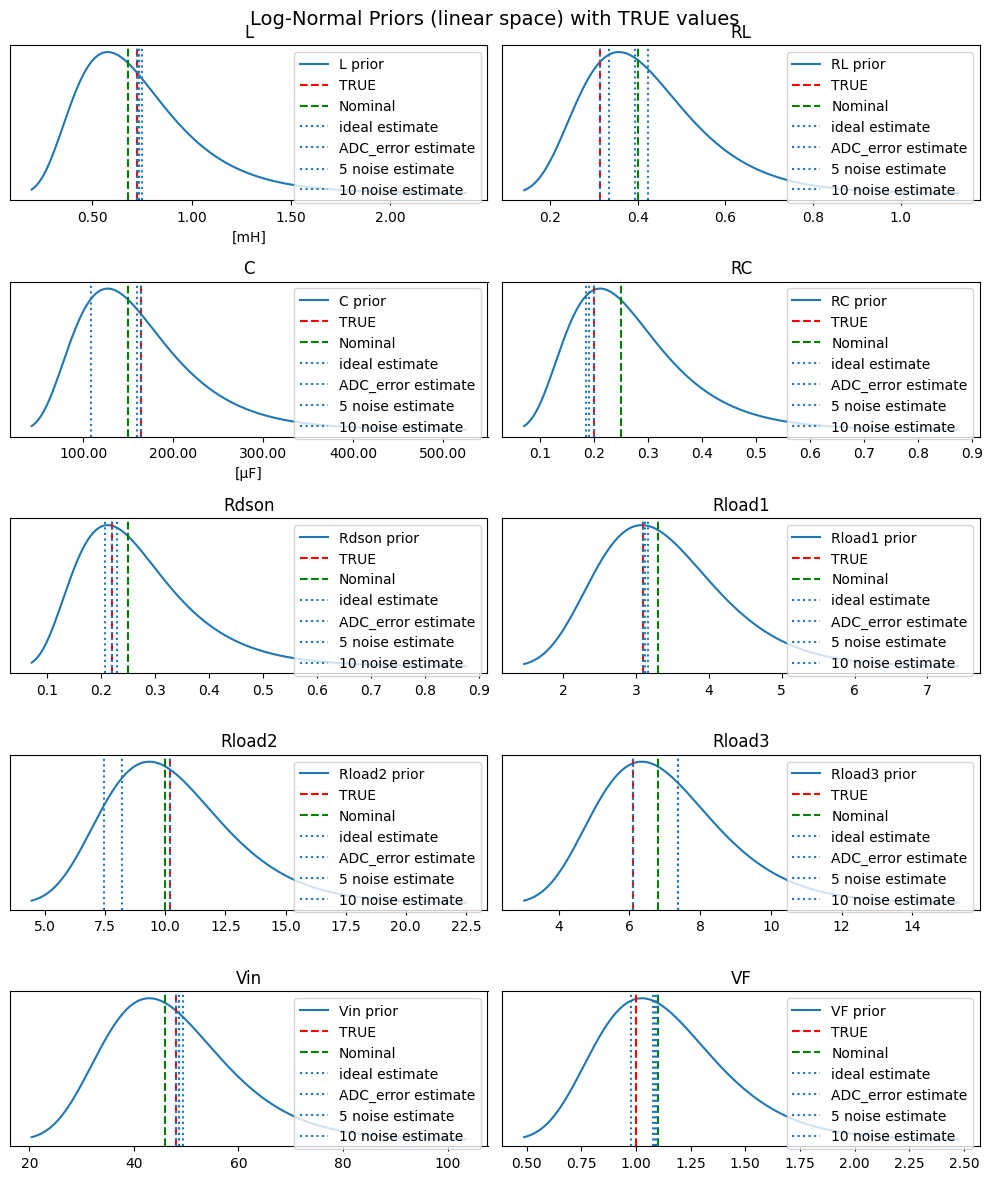

In [31]:
from typing import Dict
import matplotlib.pyplot as plt


# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}
runs_ordered: Dict[str, TrainingRun] = {
    GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)
}

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()


for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)
    estimations_for_different_runs: Dict[str, Parameters] = {
        label: getattr(run.best_parameters, name) for label, run in runs_ordered.items()
    }

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

    # plot the nominal value
    ax.axvline(nominal, color="green", linestyle="--", label="Nominal")

    for label, est in estimations_for_different_runs.items():
        ax.axvline(est, linestyle=":", label=f"{label} estimate")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()

    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Laplace Approximation

The **Laplace approximation** is a method for approximating a complex posterior distribution with a Gaussian centered at the maximum a posteriori (MAP) estimate. It assumes that the log-posterior is approximately quadratic near its peak, allowing the posterior to be approximated as:

$$
p(\theta \mid \mathcal{D}) \approx \mathcal{N}(\theta_{\text{MAP}}, \Sigma), \quad \Sigma^{-1} = \nabla^2_{\theta} [-\log p(\theta \mid \mathcal{D})] \big|_{\theta = \theta_{\text{MAP}}}
$$

This approximation provides an estimate of uncertainty around the MAP point by evaluating the curvature (i.e., the Hessian) of the negative log-posterior. 

We use the Laplace approximation to fit a Gaussian (and optionally a log-normal) distribution to the posterior over the model parameters, enabling uncertainty quantification around the point estimate obtained by optimization.

In [33]:
from torch.autograd.functional import hessian
from torch.func import functional_call
from scipy.stats import norm, lognorm
import numpy as np
import torch
from torch import nn
from torch.autograd.functional import hessian
from torch.func import functional_call
from dataclasses import dataclass
from typing import Callable, Dict, Any, List

from scipy.stats import norm, lognorm  # --- utilities

# -----------------------------------------------------------------
# user-supplied helpers
#   Parameters, make_log_param, reverse_log_param
#   log_normal_prior, rel_tolerance_to_sigma
#   likelihood_loss_triplets, _parse_data_noise_to_sigma
# must already be imported
# -----------------------------------------------------------------


# -----------------------------------------------------------------#
#   Container for the posterior                                   #
# -----------------------------------------------------------------#
@dataclass
class LaplacePosterior:
    theta_log: torch.Tensor  # MAP in log-space
    Sigma_log: torch.Tensor  # covariance in log-space
    theta_phys: torch.Tensor  # MAP in physical units
    Sigma_phys: torch.Tensor  # covariance in physical units


# -----------------------------------------------------------------#
#   LaplaceFitter class                                            #
# -----------------------------------------------------------------#
class LaplaceFitter:
    """
    Compute a Laplace (Gaussian) approximation to the posterior of a
    BuckParamEstimatorTriplets model.
    """

    # ------------- construction -----------------------------------
    def __init__(
        self,
        model: nn.Module,
        X: torch.Tensor,  # full dataset (concatenated runs)
        noise_power: torch.Tensor,  # 2×2 Σ_Δ   (already propagated)
        NOMINAL: Parameters,
        REL_TOL: Parameters,
        damping: float = 1e-6,
        device: str = "cpu",
    ):
        self.model = model.to(device)
        self.X = X.to(device)
        self.Sigma_delta = noise_power.to(device)
        self.NOMINAL = NOMINAL
        self.REL_TOL = REL_TOL
        self.damping = damping
        self.device = device

        # pre-compute scale σ for the log-normal prior
        self.prior_sigma = rel_tolerance_to_sigma(REL_TOL)

    # ------------- helper: flatten current log-parameters ---------
    def _flat_logparams(self) -> torch.Tensor:
        """Return  (P,)  vector, requires_grad=True."""
        vec = torch.cat([p.detach().clone().view(1) for p in self.model.logparams]).to(self.device)
        vec.requires_grad_(True)
        return vec

    # ------------- build closure L(θ) ------------------------------
    def _posterior_loss_fn(self) -> Callable[[torch.Tensor], torch.Tensor]:
        """
        Returns f(theta_vec) that:
            1) rewrites model parameters,
            2) runs the triplet forward,
            3) computes −log posterior.
        """
        param_keys = [name for name, _ in self.model.named_parameters()]
        assert len(param_keys) == len(Parameters._fields), "param count mismatch"

        def loss(theta_vec: torch.Tensor) -> torch.Tensor:
            # split flat θ into individual tensors with correct shapes
            split = []
            offset = 0
            for name, p0 in self.model.named_parameters():
                n = p0.numel()
                split.append(theta_vec[offset : offset + n].view_as(p0))
                offset += n

            state_dict = {k: v for k, v in zip(param_keys, split)}  # new θ
            preds, targets = functional_call(self.model, state_dict, (self.X,))

            # likelihood
            ll = likelihood_loss_triplets(preds, targets, self.Sigma_delta)

            # prior (independent log-normal)
            logparams = Parameters(*split)
            prior = log_normal_prior(logparams, self.NOMINAL, self.prior_sigma)

            return ll + prior

        return loss

    # ------------- main entry -------------------------------------
    def fit(self) -> LaplacePosterior:
        theta_map = self._flat_logparams()
        loss_fn = self._posterior_loss_fn()

        # ----- compute MAP gradient once (optional sanity check) ---
        loss_map = loss_fn(theta_map)
        loss_map.backward()

        # ----- Hessian --------------------------------------------
        H = hessian(loss_fn, theta_map)
        H = (H + H.T) * 0.5  # symmetrise

        I = torch.eye(H.shape[0], device=self.device)
        Sigma_log = torch.linalg.inv(H + self.damping * I)

        # ----- convert to physical units ---------------------------
        theta_phys = torch.tensor(
            [getattr(self.model.get_estimates(), n) for n in Parameters._fields],
            device=self.device,
        )
        J = torch.diag(theta_phys)  # ∂θ_phys/∂θ_log = diag(θ_phys)
        Sigma_phys = J @ Sigma_log @ J.T

        return LaplacePosterior(
            theta_log=theta_map.detach(),
            Sigma_log=Sigma_log,
            theta_phys=theta_phys,
            Sigma_phys=Sigma_phys,
        )

    # -------- convenience static helpers --------------------------
    @staticmethod
    def build_gaussian_approx(mean: np.ndarray, cov: np.ndarray):
        std = np.sqrt(np.diag(cov))
        return [norm(loc=m, scale=s) for m, s in zip(mean, std)]

    @staticmethod
    def build_lognormal_approx(mu_log: np.ndarray, sigma_log: np.ndarray):
        return [lognorm(s=s, scale=np.exp(m)) for m, s in zip(mu_log, sigma_log)]

    @staticmethod
    def print_parameter_uncertainty(theta_phys, Sigma_phys):
        std_phys = torch.sqrt(torch.diag(Sigma_phys))
        for i, name in enumerate(Parameters._fields):
            mean = theta_phys[i].item()
            std = std_phys[i].item()
            pct = 100.0 * std / mean
            print(f"{name:8s}: {mean:.3e} ± {std:.1e} ({pct:.2f} %)")

In [35]:
label_noise_dict = {
    "ideal": torch.tensor([[1e-9, 0.0], [0.0, 1e-9]], dtype=torch.float32),  # no noise
    "ADC_error": Sigma_tot_ADC,
    "5 noise": Sigma_tot_5,
    "10 noise": Sigma_tot_10
}

lfits = {}

for label, model in trained_models.items():
    noise_power = label_noise_dict[label]

    # Fit Laplace posterior using the new class
    laplace = LaplaceFitter(
        model=model,
        X=X,
        noise_power=noise_power,
        NOMINAL=NOMINAL,
        REL_TOL=REL_TOL,
        damping=1e-6,
        device="cpu",  # or "cuda" if using GPU
    )
    lfit = laplace.fit()

    # Compute Gaussian and LogNormal approximations
    gaussians = LaplaceFitter.build_gaussian_approx(
        mean=lfit.theta_phys.cpu().numpy(),
        cov=lfit.Sigma_phys.cpu().numpy()
    )

    lognormals = LaplaceFitter.build_lognormal_approx(
        mu_log=lfit.theta_log.cpu().numpy(),
        sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())
    )

    # Print and store
    print(f"\nParameter estimates for {label}:")
    LaplaceFitter.print_parameter_uncertainty(lfit.theta_phys, lfit.Sigma_phys)
    lfits[label] = lfit


C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\416747974.py:140: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\3138777096.py:33: RuntimeWarning: invalid value encountered in sqrt
  sigma_log=np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())



Parameter estimates for ideal:
L       : 7.240e-04 ± nan (nan %)
RL      : 3.140e-01 ± nan (nan %)
C       : 1.645e-04 ± 1.1e-08 (0.01 %)
RC      : 2.009e-01 ± 2.0e-06 (0.00 %)
Rdson   : 2.202e-01 ± nan (nan %)
Rload1  : 3.100e+00 ± 3.5e-05 (0.00 %)
Rload2  : 1.021e+01 ± nan (nan %)
Rload3  : 6.101e+00 ± 2.4e-04 (0.00 %)
Vin     : 4.796e+01 ± nan (nan %)
VF      : 9.780e-01 ± 2.0e-04 (0.02 %)

Parameter estimates for ADC_error:
L       : 7.372e-04 ± 1.8e-05 (2.42 %)
RL      : 3.344e-01 ± 5.8e-02 (17.47 %)
C       : 1.637e-04 ± 5.9e-06 (3.61 %)
RC      : 2.009e-01 ± 1.1e-03 (0.54 %)
Rdson   : 2.292e-01 ± 1.5e-02 (6.74 %)
Rload1  : 3.098e+00 ± 1.9e-02 (0.60 %)
Rload2  : 1.021e+01 ± nan (nan %)
Rload3  : 6.089e+00 ± 1.3e-01 (2.18 %)
Vin     : 4.870e+01 ± 1.1e+00 (2.32 %)
VF      : 1.096e+00 ± nan (nan %)

Parameter estimates for 5 noise:
L       : 7.357e-04 ± 5.1e-05 (6.90 %)
RL      : 3.931e-01 ± 1.3e-01 (33.37 %)
C       : 1.599e-04 ± 2.5e-06 (1.57 %)
RC      : 1.916e-01 ± nan (nan %)


In [36]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import numpy as np


def plot_laplace_posteriors(
    lfit: LaplacePosterior,
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    TRUE_PARAMS: Parameters,
    _SCALE: dict,
    runs_ordered: dict,
):
    """
    Plot Laplace approximations (Gaussian + log-normal) against log-normal prior for each parameter.
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    # Convert tensors to numpy
    theta_map_np = lfit.theta_phys.cpu().numpy()
    std_map_np = np.sqrt(torch.diag(lfit.Sigma_phys).cpu().numpy())
    mu_log_np = lfit.theta_log.cpu().detach().numpy()
    sigma_log_np = np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())

    for i, name in enumerate(param_names):
        nominal = getattr(NOMINAL, name)
        rel_tol = getattr(REL_TOL, name)
        true_val = getattr(TRUE_PARAMS, name)
        mu_post = theta_map_np[i]
        std_post = std_map_np[i]

        # Prior distribution
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)

        # Posterior (Gaussian)
        x_post_gauss = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y_post_gauss = norm(loc=mu_post, scale=std_post).pdf(x_post_gauss)

        # Posterior (log-normal, Laplace)
        mu_log = mu_log_np[i] - np.log(_SCALE[name])  # adjust for scale
        sigma_log = sigma_log_np[i]
        post_dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x_post = np.linspace(post_dist.ppf(0.001), post_dist.ppf(0.999), 500)
        y_post = post_dist.pdf(x_post)

        ax = axes[i]
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="blue", linewidth=1)
        ax.plot(
            x_post_gauss,
            y_post_gauss,
            label="Laplace Posterior (Gaussian)",
            color="orange",
            linewidth=1,
        )
        ax.plot(x_post, y_post, label="Laplace Posterior (log-normal)", color="black", linewidth=2)

        # markers
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
        ax.axvline(nominal, color="green", linestyle="--", label="Nominal")
        ax.axvline(mu_post, color="purple", linestyle="-.", label="MAP Estimate")
        
        # point estimates from other runs
        # for label, run in runs_ordered.items():
        #     est = getattr(run.best_parameters, name)
        #     ax.axvline(est, linestyle=":", label=f"{label} estimate")

        ax.set_title(name)
        ax.set_yticks([])

        # Format axis labels
        if name == "L":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
            ax.set_xlabel("[mH]")
        elif name == "C":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
            ax.set_xlabel("[μF]")

        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Prior (log-normal) and Laplace Posterior for Each Parameter", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\2724946172.py:26: RuntimeWarning: invalid value encountered in sqrt
  std_map_np = np.sqrt(torch.diag(lfit.Sigma_phys).cpu().numpy())
C:\Users\JC28LS\AppData\Local\Temp\ipykernel_3020\2724946172.py:28: RuntimeWarning: invalid value encountered in sqrt
  sigma_log_np = np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())


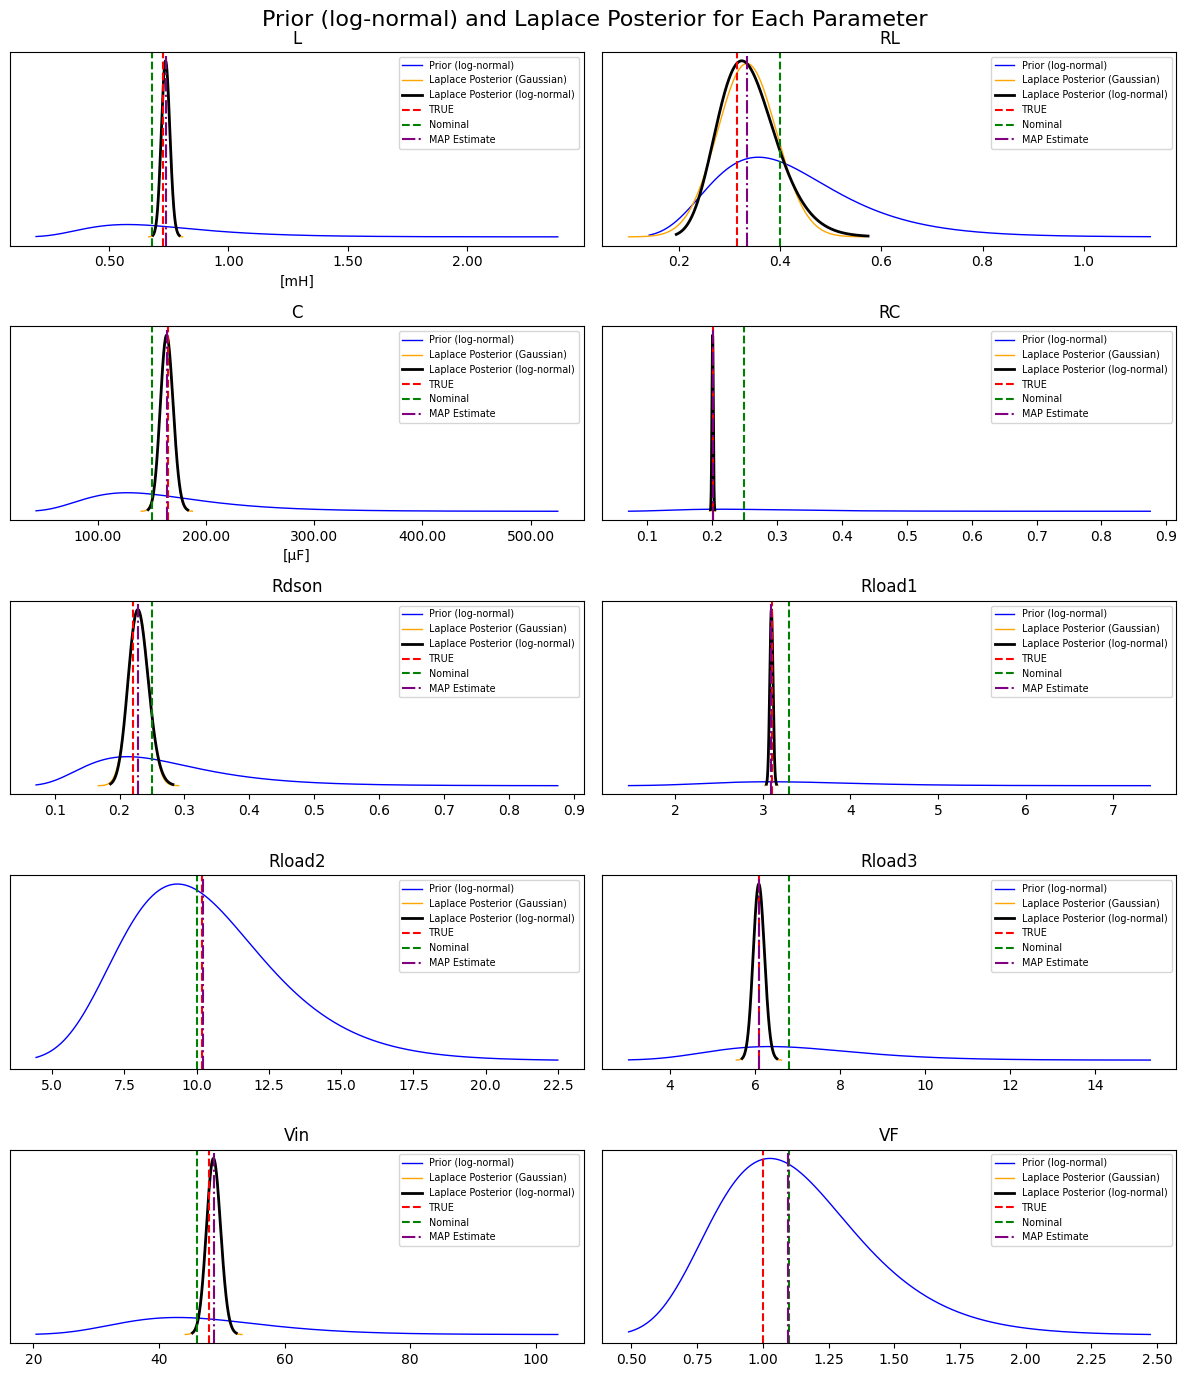

In [39]:
label = "ADC_error"  # change this to "ideal", "5 noise", or "10 noise" as needed

lfit = lfits[label]
plot_laplace_posteriors(
    lfit = lfit,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    TRUE_PARAMS=TRUE_PARAMS,
    _SCALE=_SCALE,
    runs_ordered=runs_ordered,
)

In [ ]:
def plot_single_laplace_posterior(
    param_name: str,
    lfit: LaplacePosterior,
    _SCALE: dict,
    ax: plt.Axes,
    label: str,
    style: str = "log-normal",  # or "gaussian"
    color: str = None,
    plot_prior: bool = False,
    NOMINAL: Parameters = None,
    REL_TOL: Parameters = None,
    TRUE_PARAMS: Parameters = None,
    show_map_marker: bool = True,
    marker_kwargs: dict = None,
):
    """
    Plot a single Laplace posterior distribution and optionally the prior,
    with a square marker at the MAP estimate placed on the PDF curve.

    Args:
        param_name: name of the parameter
        theta_phys: MAP in physical units
        Sigma_phys: covariance in physical units
        theta_log: MAP in log space
        Sigma_log: covariance in log space
        _SCALE: scaling dictionary
        ax: matplotlib axis to draw on
        label: label for the posterior
        style: 'log-normal' or 'gaussian'
        color: curve and marker color
        plot_prior: show log-normal prior
        NOMINAL, REL_TOL: required if plot_prior is True
        show_map_marker: draw square on posterior at MAP
        marker_kwargs: customization for square marker
    """
    param_names = Parameters._fields
    idx = param_names.index(param_name)

    mu_post = lfit.theta_phys[idx].item()
    std_post = float(torch.sqrt(lfit.Sigma_phys[idx, idx]))

    if plot_prior:
        if NOMINAL is None or REL_TOL is None:
            raise ValueError("NOMINAL and REL_TOL must be provided to plot the prior.")
        nominal = getattr(NOMINAL, param_name)
        rel_tol = getattr(REL_TOL, param_name)
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="black", linewidth=2)
        if show_map_marker:
            y_nominal_prior = prior_dist.pdf(nominal)
            default_marker_kwargs = {"marker": "s", "color": "black", "s": 30, "zorder": 5}
            ax.scatter([nominal], [y_nominal_prior], **default_marker_kwargs)

    if style == "gaussian":
        x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y = norm(loc=mu_post, scale=std_post).pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = norm(loc=mu_post, scale=std_post).pdf(mu_post)
    elif style == "log-normal":
        mu_log = lfit.theta_log[idx].item() - np.log(_SCALE[param_name])
        sigma_log = float(torch.sqrt(lfit.Sigma_log[idx, idx]))
        dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
        y = dist.pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = dist.pdf(mu_post)
    else:
        raise ValueError(f"Unknown style '{style}'; use 'gaussian' or 'log-normal'.")

    line_color = line.get_color() if color is None else color

    # Add square marker on the curve at the MAP
    if show_map_marker:
        default_marker_kwargs = {"marker": "s", "color": line_color, "s": 30, "zorder": 5}
        if marker_kwargs:
            default_marker_kwargs.update(marker_kwargs)
        ax.scatter([mu_post], [y_map], **default_marker_kwargs)

    if TRUE_PARAMS is not None:
        true_val = getattr(TRUE_PARAMS, param_name)
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE", linewidth=1)

    ax.set_title(param_name)
    ax.set_yticks([])

    if param_name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    elif param_name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

def plot_all_laplace_posteriors_grid(
    lfits: dict[str, LaplacePosterior],
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    _SCALE: dict,
    TRUE_PARAMS: Parameters = None,
    skip_labels: set = {"ideal"},
    style: str = "log-normal",
):
    """
    Plot posterior PDFs from Laplace approximation for all parameters in a grid.

    Args:
        trained_models: dict[label] -> trained model
        X, y: input data tensors
        NOMINAL, REL_TOL: prior hyperparams
        _SCALE: scaling dict
        label_noise_dict: dict[label] -> data_noise_power
        TRUE_PARAMS: optional, used to show true value marker
        skip_labels: set of labels to skip (e.g. 'ideal')
        style: 'log-normal' or 'gaussian'
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    for i, param_name in enumerate(param_names):
        ax = axes[i]
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Only show prior and true param once
        show_prior = True
        true_params = TRUE_PARAMS

        for label, fit in lfits.items():
            if label in skip_labels:
                continue
            plot_single_laplace_posterior(
                param_name=param_name,
                lfit=fit,
                _SCALE=_SCALE,
                ax=ax,
                label=label,
                style=style,
                plot_prior=show_prior,
                NOMINAL=NOMINAL,
                REL_TOL=REL_TOL,
                show_map_marker=True,
                marker_kwargs={"label": None},  # avoid duplicate legend entry
                TRUE_PARAMS=true_params,
            )
            if show_prior:
                show_prior = False  # only plot once
            true_params = None

        # Add true value line (if provided)
        if TRUE_PARAMS:
            true_val = getattr(TRUE_PARAMS, param_name)
            ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

        ax.set_title(param_name)
        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Laplace Posteriors with Varying Data Noise", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

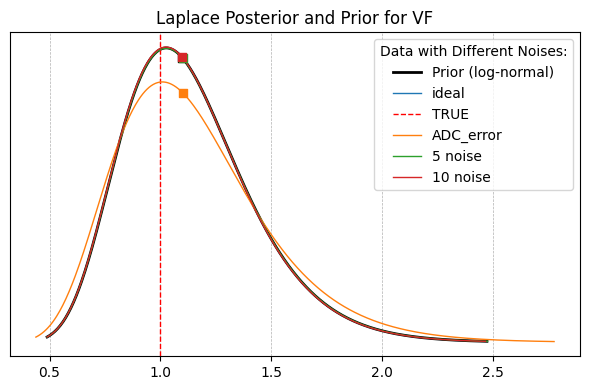

In [ ]:
parameter_name = "VF"


fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plot_prior = True
true_params = TRUE_PARAMS
for label, lfit in lfits.items():

    plot_single_laplace_posterior(
        param_name=parameter_name,
        lfit = lfit,
        _SCALE=_SCALE,
        ax=ax,
        label=label,
        style="log-normal",
        plot_prior=plot_prior,
        NOMINAL=NOMINAL,
        REL_TOL=REL_TOL,
        TRUE_PARAMS=true_params,
    )

    ax.legend(title="Data with Different Noises:")
    ax.set_title("Laplace Posterior and Prior for " + parameter_name)
    plt.tight_layout()
    plot_prior = False  # only plot prior once
    true_params = None  # don't plot TRUE_PARAMS again

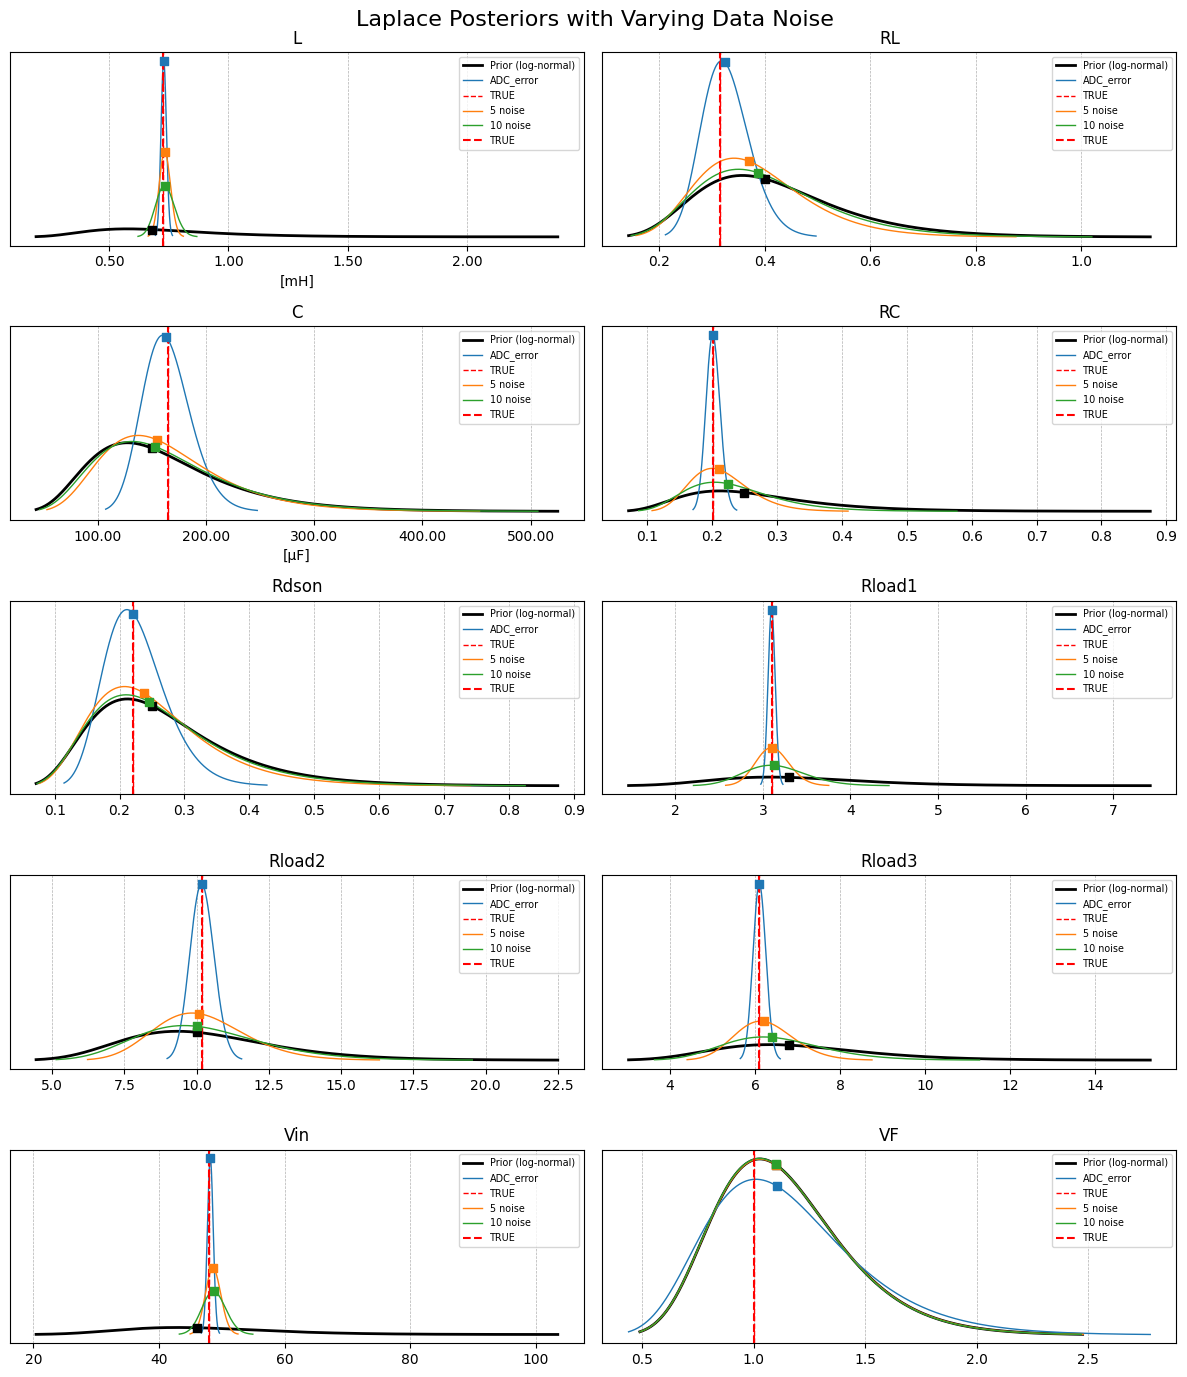

In [ ]:
plot_all_laplace_posteriors_grid(
    lfits=lfits,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    _SCALE=_SCALE,
    TRUE_PARAMS=TRUE_PARAMS,
)

Great! We have obtained posterior distributions on the estimations, which depend on the nose of the input data. 


## Limitations

#### 0. Choice of Priors 
The choice of priors is done by inspection

## Remedies and Next Steps

For points 1 and 3 we can think of different approaches to solve this problem. 

1. Rather than simply considering $x_{\text{obs}}$, estimate the true x considering this as a latent variable

2. Model the noise scale explicitly, learning $\sigma^2$ as a latent variable.

2. Use full Bayesian inference, these return better estimations of the posterior p(z | y, x): 
    + VI approach: should still be possible to use automatic-diff + Adam. 
    + HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

---

Also, the prior effect is quite strong when the data is noisy. This may be correct and could be resolved with the previous points, but we can see what happens if we use uniform priors or **empirical Bayes**, which are chosen in a data-driven manner (maybe we can keep the nominal and only estimate $\sigma$ in this way). 